# 8.1 Comparison between reconstucted terms of ERA5 and SD transects. 


Packages

In [1]:
import pathlib
from pathlib import Path
import os 

import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import cmocean as cmo
import scipy
from scipy import stats
import netCDF4
from netCDF4 import Dataset as nc
import cartopy.crs as ccrs
import matplotlib
import seaborn as sns

from AirSeaFluxCode import AirSeaFluxCode

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
import math

font = {'weight' : 'normal',
        'size'  : 20}
matplotlib.rc('font', **font)

Functions

In [2]:
import math
def wind_sp_kt_to_ms(wind_kts):
    
    return wind_kts*0.514444  #kt to m/s

def wind_sp_to_10m(wind_sp, z0=1.52e-4, zm=3.4, z10=10):
    
    """Correct wind speed data from a given height to 10m above sea level.

       wind_sp = wind speed measurement (m/s)
       z0      = roughness length
       zm      = height of wind measurement
       z10     = height to correct to
    """
    
    return wind_sp*(math.log(z10/z0)/math.log(zm/z0))

def wind_direction(v, u):
    DIR=90-np.rad2deg(np.arctan(v / u) )
    return DIR

from tqdm import tqdm  # Assuming you're using the tqdm library for progress tracking

def colocate_era5_sd(sd, era5, var):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.
    - var (str): The variable to be colocated.

    Returns:
    - era5_var (numpy.ndarray): An array of ERA5 variable values colocated with SD.
    """

    # Initialize an empty array to store ERA5 variable values
    era5_var = np.ndarray(sd.time.size)

    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        era5_var[t] = era5[var].isel(time=idx, latitude=lat_idx, longitude=lon_idx).data

    return era5_var

def era5dewtorh(era5_ds):
    # Extract dew point temperature (Dp) values from the input dataset
    Dp = era5_ds.d2m.values # dew point temperature in °C

    # Extract air temperature (T) values from the input dataset
    T = era5_ds.t2m.values # temperature in °C
    
    # Calculate relative humidity (RH) using the formula and add it to the input dataset
    era5_ds['rh'] = (('time', 'latitude', 'longitude'),
                     100 * (np.exp((17.625 * Dp) / (243.04 + Dp)) / np.exp((17.625 * T) / (243.04 + T))))
    
    # Return the input dataset with the 'rh' variable added
    return era5_ds

def dist_era5_sd(sd, era5):
    """
    Colocates ERA5 data with Shipboard Data (SD) based on time, latitude, and longitude.

    Args:
    - sd (xarray.Dataset): Shipboard Data with time, longitude, and latitude dimensions.
    - era5 (xarray.Dataset): ERA5 data with time, longitude, and latitude dimensions.

    Returns:
    - dist (numpy.ndarray): An array of distance in meters between nearest ERA5 gridpoint and SD.
    """

    # Initialize an empty array to store ERA5 variable values
    dist = np.ndarray(sd.time.size)
    #time = np.ndarray(sd.time.size)
    # Iterate through each time step in Shipboard Data (SD)
    for t in tqdm(range(sd.time.size)):

        # Find the matching time index in ERA5 data
        idx = sd.time[t] == era5.time

        # Find the latitude and longitude indices in ERA5 data that are closest to SD coordinates
        lon_idx = np.argmin(np.abs(sd.longitude.data[t] - era5.longitude.data))
        lat_idx = np.argmin(np.abs(sd.latitude.data[t] - era5.latitude.data))

        # Extract and store the ERA5 variable value for the matching time and location
        dist[t] = gsw.distance([era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['longitude'].data, sd.longitude[t]],[era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['latitude'].data, sd.latitude[t]]) 
        
        #dist[t]= (((era5.latitude[lat_idx]-sd.latitude[lat_idx])**2)+((era5.longitude[lon_idx]-sd.longitude[lon_idx])**2))**0.5
        #time[t] = era5.isel(time=idx, latitude=lat_idx, longitude=lon_idx)['time']
        
        
    return dist

Load datasets

In [3]:
ds=xr.open_dataset( pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ds.nc')
ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ERA5file.nc')
coloc3=pd.read_csv(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/coloc3.csv') #open coloc3
dsadcpH=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/dsadcpH.nc')
ostia=xr.open_dataset(pathlib.Path('.').absolute().parent/'MTmichaela/MasterH23/ostia.nc')
ERA5big=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5big.nc')
ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ostia_regrid.nc')
coloc4=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/coloc4.csv')

ERA5_ostia_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_rec.csv').to_xarray() #reconstructed terms ERA5 w ostia sst
ERA5_bulk_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_rec.csv').to_xarray() #reconstructed terms ERA5
ERA5_skin_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_rec.csv').to_xarray() #reconstructed terms ERA5
SD_rec=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_rec.csv').to_xarray() #reconstructed terms SD

ERA5_ostia_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_ostia_sst_ASFC.csv') #ASFC output ERA5 (coloc3) w ostia sst
ERA5_skin_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_skin_ASFC.csv') #ASFC output ERA5 w skin sst(coloc3)
ERA5_bulk_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/ERA5_bulk_ASFC.csv') #ASFC output ERA5 w bulk sst(coloc3)

SD_ASFC=pd.read_csv(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SD_ASFC.csv') #ASFC output SD

SSH=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/SSH.nc')

## Correlation plots between SD and ERA5 reconstructed terms.

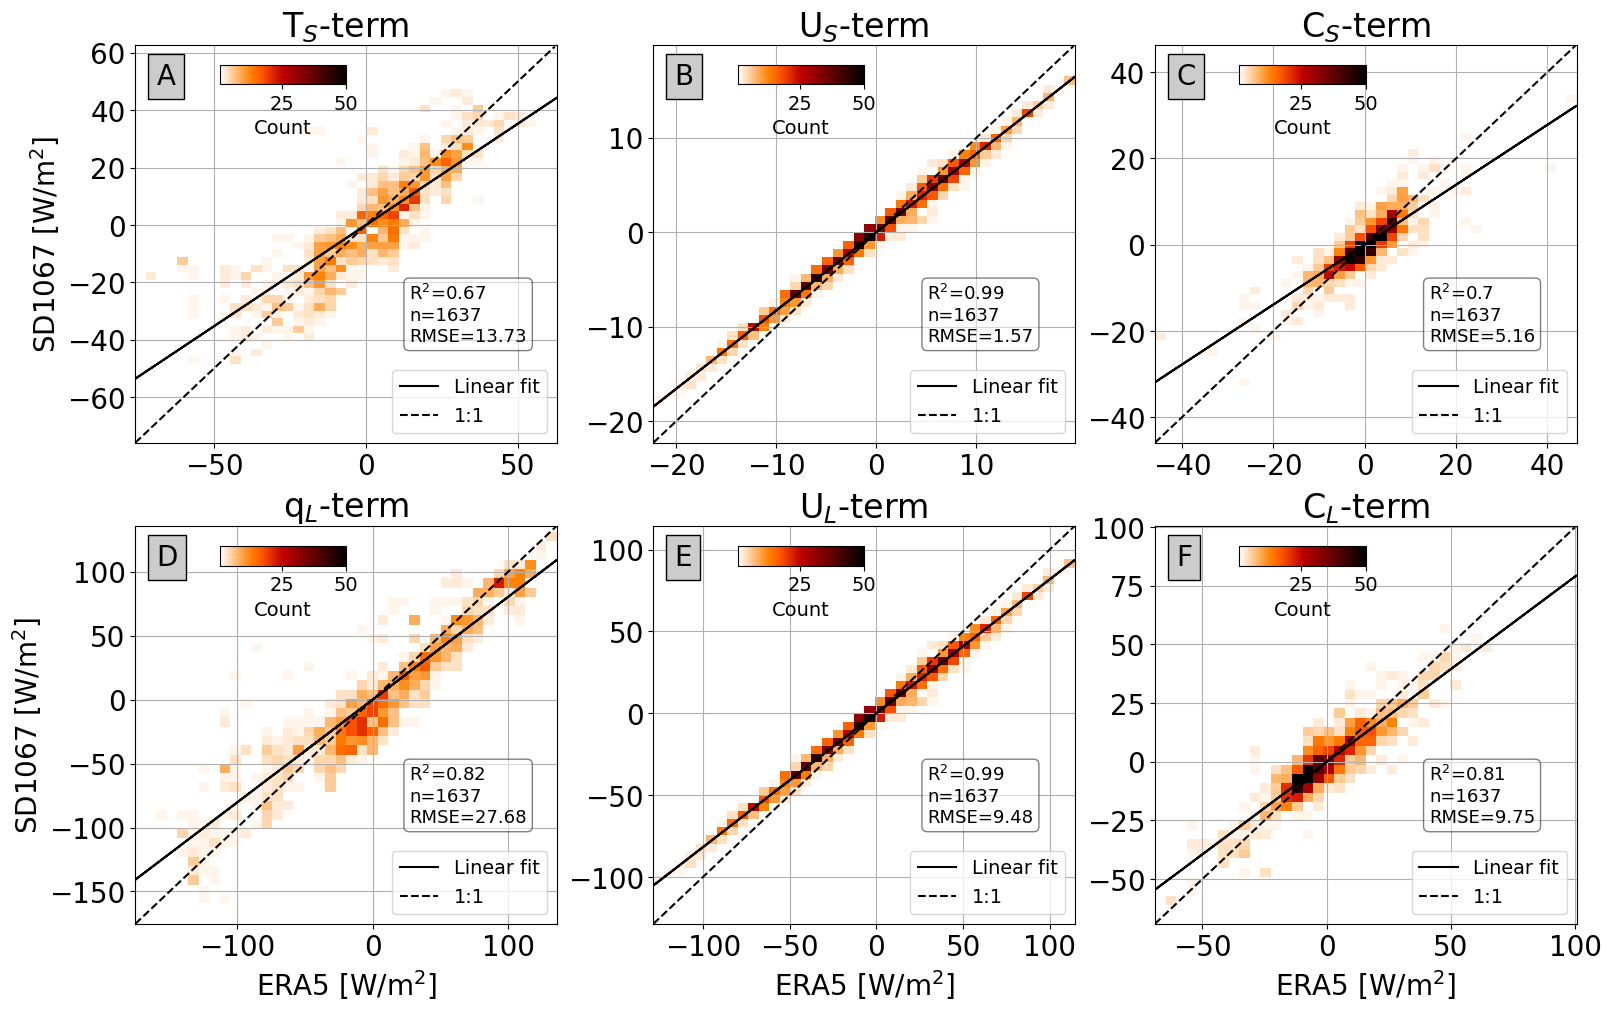

In [4]:
fig, ax=plt.subplots(2,3, figsize=[16,10], constrained_layout=True)

s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

fig_label=[['A','B','C'],['D','E','F']]

bbox = dict(boxstyle="square", fc="0.8")

ticksize=14

text_x=0.05
text_y=0.9

for i in np.arange(3):
    msk=np.isfinite(ERA5_skin_rec[s_terms[i]])
    msk1=np.isfinite(SD_rec[s_terms[i]])
    
    x= ERA5_skin_rec.shf_coeffs*ERA5_skin_rec[s_terms[i]].sel(index=(msk & msk1))
    y= SD_rec.shf_coeffs*SD_rec[s_terms[i]].sel(index= (msk & msk1))

    
    wind1=ax[0,i].hist2d(x, y, bins=40, cmin=1,cmap='gist_heat_r', vmax=50)
    #ax[0,i].scatter(x, y) #Idea is to color by wind, then we can see if there is issues at high or low windspeeds

    
    cax = ax[0,i].inset_axes([0.2, 0.9, 0.3, 0.05])
    cbar=fig.colorbar(wind1[3], cax=cax, label=('Count'), orientation='horizontal')
    #Create linear fit line and plot
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.set_label(label='Count', size=ticksize)
#cax = ax[0,i].inset_axes([0.3, 0.07, 0.4, 0.04])
#fig.colorbar(pcm, cax=cax, orientation='horizontal')

    ax[0,i].set_xlim(x.min(), x.max())
    ax[0,i].set_ylim(x.min(), x.max())

    ax[0,i].annotate(fig_label[0][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
  #####################################################  
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[0,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[0,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[0,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)

    msk=np.isfinite(SD_rec[l_terms[i]])
    msk1=np.isfinite(ERA5_skin_rec[l_terms[i]])
    
    x= ERA5_skin_rec.lhf_coeffs*ERA5_skin_rec[l_terms[i]].sel(index=(msk& msk1))
    y= SD_rec.lhf_coeffs*SD_rec[l_terms[i]].sel(index=(msk& msk1))
    
    
    #ax[1,i].scatter(x, y)
    wind2= ax[1,i].hist2d(x, y, bins=40, cmin=1, label=labelL[i],cmap='gist_heat_r', vmax=50)
    cax = ax[1,i].inset_axes([0.2, 0.9, 0.3, 0.05])
    
    cbar=fig.colorbar(wind2[3], cax=cax, label=('Count'), orientation='horizontal')
    cbar.ax.tick_params(labelsize=ticksize)
    
    cbar.set_label(label='Count', size=ticksize)
    #cbar.set_fontsize(20)
    
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[1,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[1,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr='R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    


    ax[1,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)
    ax[1,i].annotate(fig_label[1][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
#    ax[0,i].set_title('Q$_S´$')
#    ax[1,i].set_title('Q$_L´$')
    
    ax[0,i].set_title(labelS[i])    
    ax[1,i].set_title(labelL[i])

    
    ax[0,i].grid()
    ax[1,i].grid()
    
    ax[0,i].legend(loc='lower right', fontsize='x-small')
    ax[1,i].legend(loc='lower right', fontsize='x-small')

    ax[1,i].set_xlim(x.min(), x.max())
    ax[1,i].set_ylim(x.min(), x.max())
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

ax[0,0].set_ylabel('SD1067 [W/m$^2$]')
ax[1,0].set_ylabel('SD1067 [W/m$^2$]')

ax[1,0].set_xlabel('ERA5 [W/m$^2$]')
ax[1,1].set_xlabel('ERA5 [W/m$^2$]')
ax[1,2].set_xlabel('ERA5 [W/m$^2$]')

    
plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/ERA5-SD-terms.png')

## Correlation with OSTIA sst data in computation

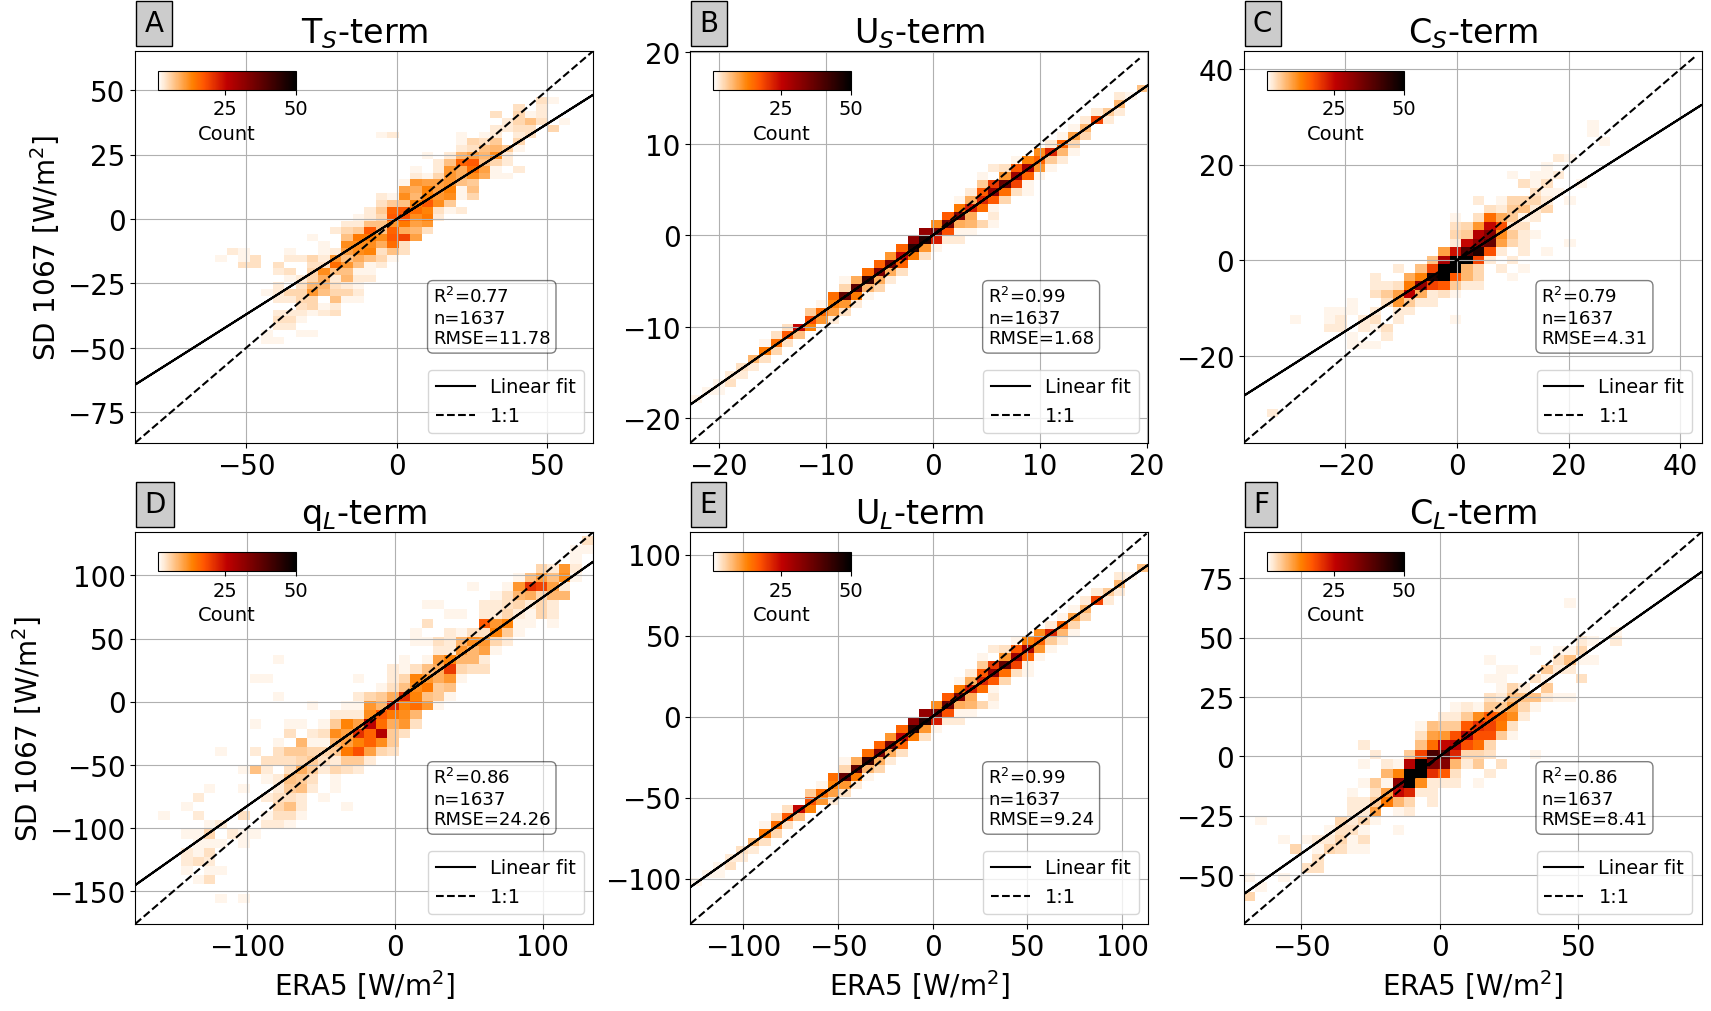

In [5]:
fig, ax=plt.subplots(2,3, figsize=[17,10], constrained_layout=True)

s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

fig_label=[['A','B','C'],['D','E','F']]

bbox = dict(boxstyle="square", fc="0.8")

ticksize=14


text_x=0.02
text_y=1.05

for i in np.arange(3):
    msk=np.isfinite(SD_rec[s_terms[i]])
    msk1=np.isfinite(ERA5_ostia_rec[s_terms[i]])
    
    x= ERA5_ostia_rec.shf_coeffs*ERA5_ostia_rec[s_terms[i]].sel(index=(msk&msk1))
    y= SD_rec.shf_coeffs*SD_rec[s_terms[i]].sel(index=(msk&msk1))

    
    wind1=ax[0,i].hist2d(x, y, bins=40, cmin=1,cmap='gist_heat_r', vmax=50)
    #ax[0,i].scatter(x, y) #Idea is to color by wind, then we can see if there is issues at high or low windspeeds
    cax = ax[0,i].inset_axes([0.05, 0.9, 0.3, 0.05])
    cbar=fig.colorbar(wind1[3], cax=cax, label=('Count'), orientation='horizontal')
    #Create linear fit line and plot
    cbar.ax.tick_params(labelsize=ticksize)
    cbar.set_label(label='Count', size=ticksize)
#cax = ax[0,i].inset_axes([0.3, 0.07, 0.4, 0.04])
#fig.colorbar(pcm, cax=cax, orientation='horizontal')

    ax[0,i].set_xlim(x.min(), x.max())
    ax[0,i].set_ylim(x.min(), x.max())

    ax[0,i].annotate(fig_label[0][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
    
    #obtain m (slope) and b(intercept) of linear regression line
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[0,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[0,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr= 'R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[0,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)

    msk=np.isfinite(SD_rec[l_terms[i]])
    msk1=np.isfinite(ERA5_ostia_rec[l_terms[i]])
    
    x= ERA5_ostia_rec.lhf_coeffs*ERA5_ostia_rec[l_terms[i]].sel(index=(msk&msk1))
    y= SD_rec.lhf_coeffs*SD_rec[l_terms[i]].sel(index=(msk&msk1))
    
    
    #ax[1,i].scatter(x, y)
    wind2= ax[1,i].hist2d(x, y, bins=40, cmin=1, label=labelL[i],cmap='gist_heat_r', vmax=50)
    cax = ax[1,i].inset_axes([0.05, 0.9, 0.3, 0.05])
    
    cbar=fig.colorbar(wind2[3], cax=cax, label=('Count'), orientation='horizontal')
    cbar.ax.tick_params(labelsize=ticksize)
    
    cbar.set_label(label='Count', size=ticksize)
    #cbar.set_fontsize(20)
    
    m, b = np.polyfit(x, y, 1)
    
    #add linear regression line to scatterplot 
    ax[1,i].plot(x, m*x+b, color='k', label='Linear fit')
    ax[1,i].plot(np.arange(x.min(), x.max(), 1), np.arange(x.min(), x.max(), 1) , linestyle='--', color='k', label=('1:1'))
    #Create stats and statbox
    RMSE = math.sqrt(mean_squared_error(x, y))
    
    r2=scipy.stats.linregress(x, y).rvalue**2
    n = len(x)
    #p= scipy.stats.linregress(coloc3msk[colocno[i]], dsadcpH[var[i]].sel(time=np.isfinite(dsadcpH[var[i]]))).pvalue
    
    textstr='R$^2$='+ str(round(r2, 2)) + '\n'+ 'n=' +str(n) + '\n' + 'RMSE='+ str(round(RMSE,2)) 
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    


    ax[1,i].annotate(textstr, xy=(0.65, 0.4), xycoords='axes fraction', bbox=props, va='top',fontsize=13)
    ax[1,i].annotate(fig_label[1][i], xy=(text_x, text_y), xycoords='axes fraction', bbox=bbox)
#    ax[0,i].set_title('Q$_S´$')
#    ax[1,i].set_title('Q$_L´$')
    
    ax[0,i].set_title(labelS[i])    
    ax[1,i].set_title(labelL[i])

    
    ax[0,i].grid()
    ax[1,i].grid()
    
    ax[0,i].legend(loc='lower right', fontsize='x-small')
    ax[1,i].legend(loc='lower right', fontsize='x-small')

    ax[1,i].set_xlim(x.min(), x.max())
    ax[1,i].set_ylim(x.min(), x.max())
#    mask = ~np.isnan(varprime.Qs) & ~np.isnan(varprime.deltaT)

#    scipy.stats.linregress(varprime.Qs[mask], varprime.deltaT[mask])

ax[0,0].set_ylabel('SD 1067 [W/m$^2$]')
ax[1,0].set_ylabel('SD 1067 [W/m$^2$]')

ax[1,0].set_xlabel('ERA5 [W/m$^2$]')
ax[1,1].set_xlabel('ERA5 [W/m$^2$]')
ax[1,2].set_xlabel('ERA5 [W/m$^2$]')

    
plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/ERA5-ostia-SD-.png')

## Timeseries ERA5 and SD fluxes

* Add stats somehow

In [6]:
np.abs((SD_ASFC.sensible+SD_ASFC.latent)-(ERA5_skin_ASFC.sensible+ERA5_skin_ASFC.latent)).max()

215.39813067958386

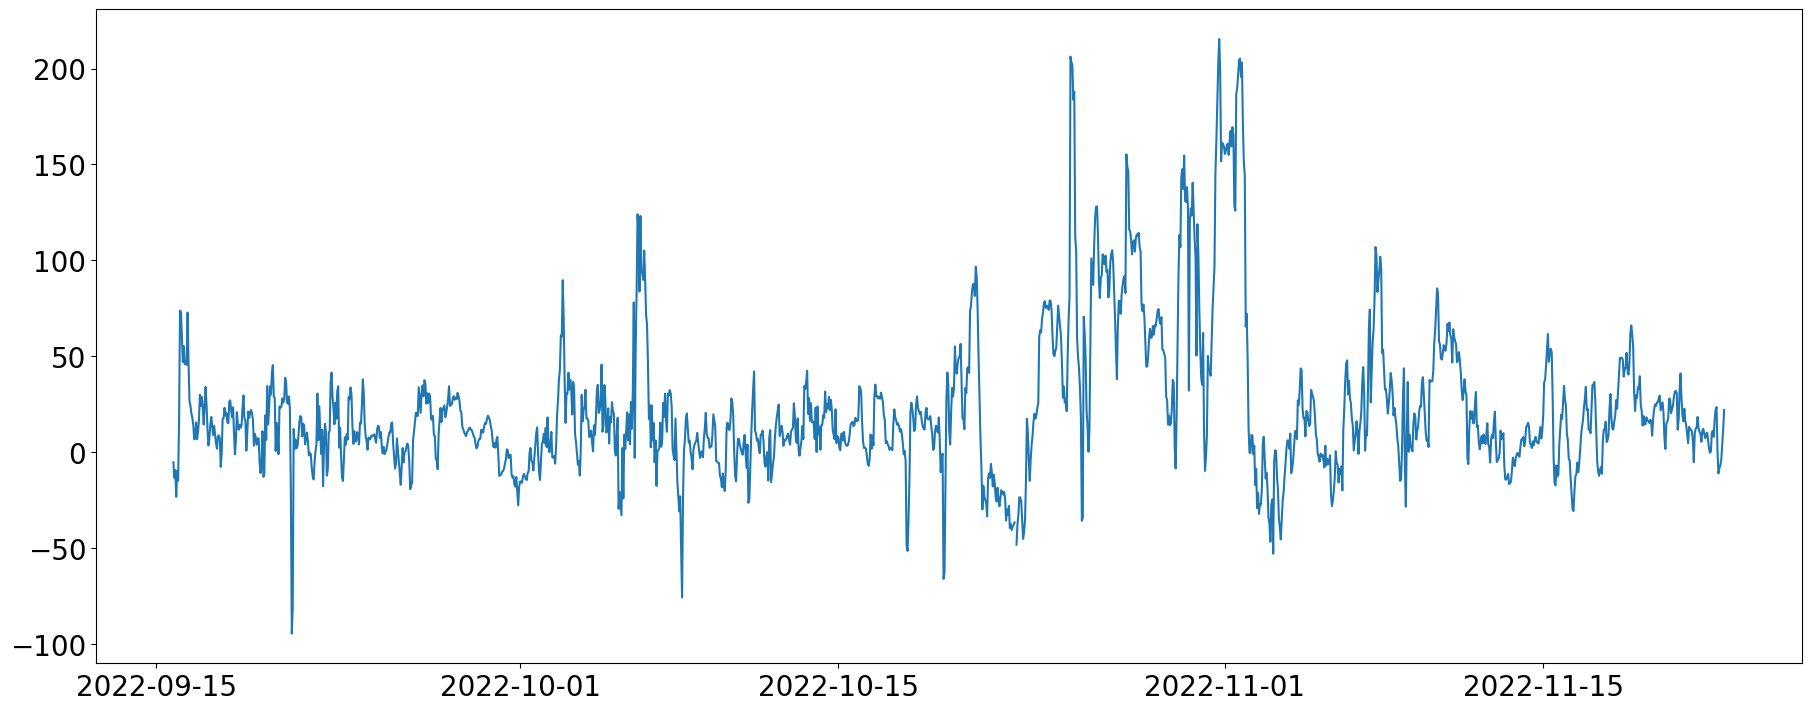

In [7]:
fig, ax=plt.subplots(1,1, figsize=[18,7], sharex=True, constrained_layout=True)
plt.plot(dsadcpH.time, (SD_ASFC.sensible+SD_ASFC.latent)-(ERA5_skin_ASFC.sensible+ERA5_skin_ASFC.latent))

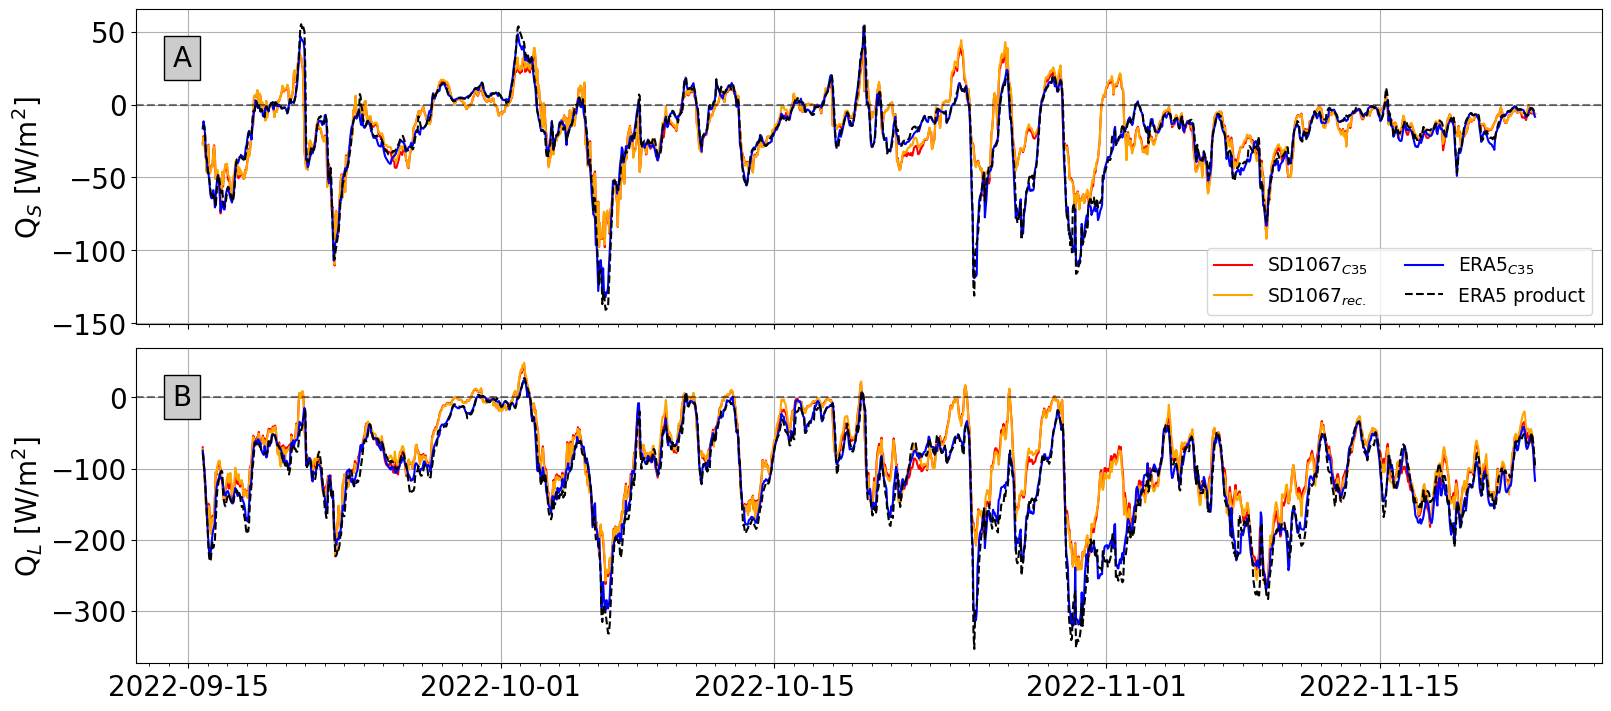

In [8]:
bajs=2
fig, ax=plt.subplots(bajs,1, figsize=[16,7], sharex=True, constrained_layout=True)

ax[0].plot(dsadcpH.time, SD_ASFC.sensible, label='SD1067$_{C35}$', c='red')
ax[0].plot(dsadcpH.time, SD_rec.shf_recomposed, label='SD1067$_{rec.}$', c='orange')
#ax[0].plot(dsadcpH.time, rec_ERA5.shf_recomposed, label='ERA5$_{rec.}$',c='navy')


ax[0].plot(dsadcpH.time, ERA5_skin_ASFC.sensible, label='ERA5$_{C35}$ ',c='blue')
#ax[0].plot(dsadcpH.time, ERA5_bulk_ASFC.sensible, label='ERA5$_{ASFC}$ (bulk sst)',c='k')
ax[0].plot(dsadcpH.time, coloc4.sensible, label='ERA5 product',c='k', linestyle='--')
ax[0].set_ylabel('Q$_S$ [W/m$^2$]')

ax[1].plot(dsadcpH.time, SD_ASFC.latent, label='SD 1067$_{C35}$', c='red')
ax[1].plot(dsadcpH.time, SD_rec.lhf_recomposed, label='SD1067$_{rec.}$', c='orange')
#ax[1].plot(dsadcpH.time, rec_ERA5.lhf_recomposed, label='ERA5$_{rec.}$',c='navy')

ax[1].plot(dsadcpH.time, ERA5_skin_ASFC.latent, label='ERA5$_{C35}$',c='blue')
#ax[1].plot(dsadcpH.time, ERA5_bulk_ASFC.latent, label='ERA5$_{ASFC}$',c='k')
ax[1].plot(dsadcpH.time, coloc4.latent, label='ERA5 product',c='k', linestyle='--')

ax[1].set_ylabel('Q$_L$ [W/m$^2$]')


ax[0].legend(fontsize=13.5, ncols=2, loc='lower right')
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

bbox = dict(boxstyle="square", fc="0.8")


ax[0].annotate('A', xy=(0.025,0.82), xycoords='axes fraction', bbox=bbox)
ax[1].annotate('B', xy=(0.025,0.82), xycoords='axes fraction', bbox=bbox)


for i in np.arange(bajs):
    ax[i].grid()
    ax[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
#    ax[i].legend()

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/Flux_ts.png')

Pure fluxes fig

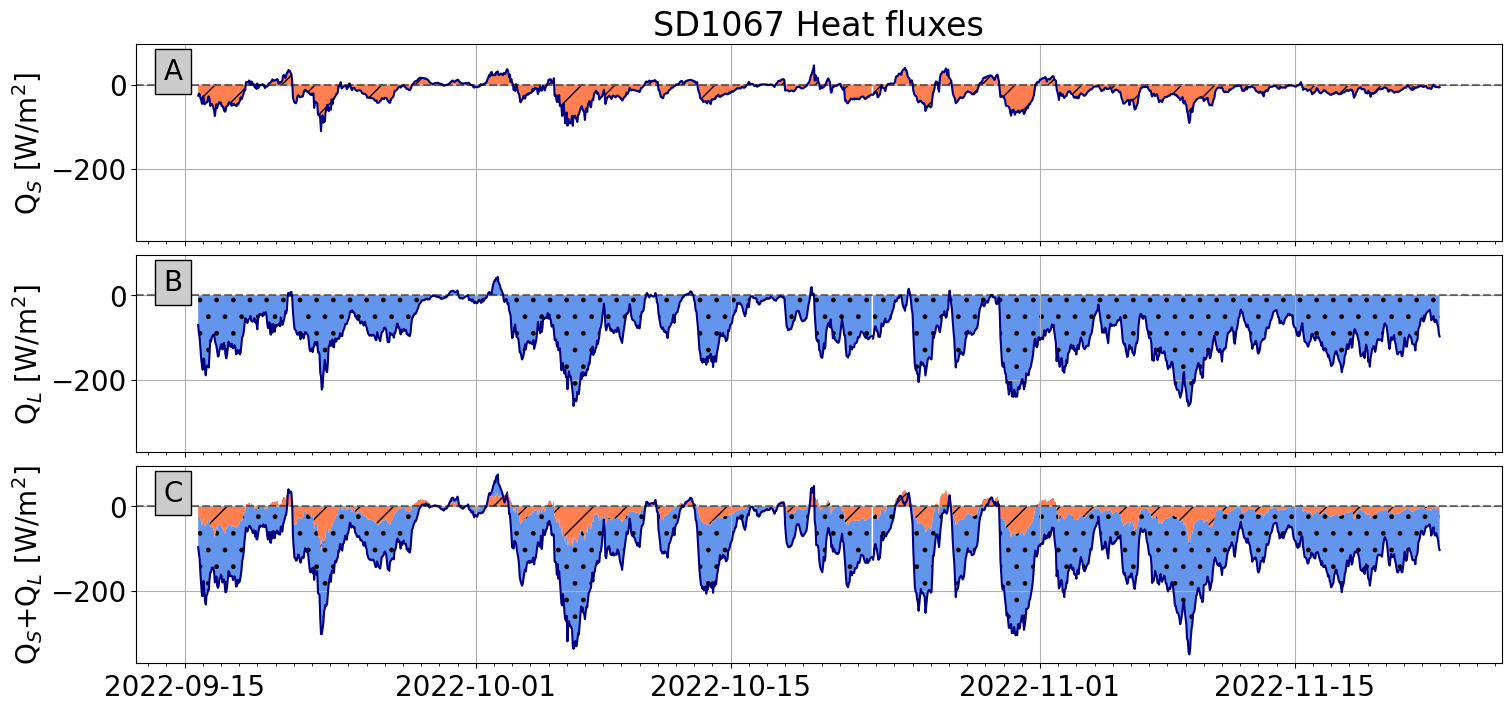

In [4]:
bajs=3
fig, ax=plt.subplots(bajs,1, figsize=[15,7], sharex=True, sharey=True, constrained_layout=True)

ax[0].plot(dsadcpH.time, SD_ASFC.sensible, label='Saildrone 1067', c='navy')
#ax[0].plot(dsadcpH.time, SD_rec.shf_recomposed, label='SD 1067$_{rec.}$', c='orange')
#ax[0].plot(dsadcpH.time, rec_ERA5.shf_recomposed, label='ERA5$_{rec.}$',c='navy')


#ax[0].plot(dsadcpH.time, ERA5_skin_ASFC.sensible, label='ERA5$_{ASFC}$ (skin sst)',c='blue')
#ax[0].plot(dsadcpH.time, ERA5_bulk_ASFC.sensible, label='ERA5$_{ASFC}$ (bulk sst)',c='k')
#ax[0].plot(dsadcpH.time, coloc4.sensible, label='ERA5 product',c='k', linestyle='--')
ax[0].set_ylabel('Q$_S$ [W/m$^2$]')

ax[1].plot(dsadcpH.time, SD_ASFC.latent, label='Saildrone 1067', c='navy')
#ax[1].plot(dsadcpH.time, SD_rec.lhf_recomposed, label='SD 1067$_{rec.}$', c='orange')
#ax[1].plot(dsadcpH.time, rec_ERA5.lhf_recomposed, label='ERA5$_{rec.}$',c='navy')

#ax[1].plot(dsadcpH.time, ERA5_skin_ASFC.latent, label='ERA5$_{ASFC}$',c='blue')
#ax[1].plot(dsadcpH.time, ERA5_bulk_ASFC.latent, label='ERA5$_{ASFC}$',c='k')
#ax[1].plot(dsadcpH.time, coloc4.latent, label='ERA5 product',c='k', linestyle='--')

ax[2].plot(dsadcpH.time, SD_ASFC.sensible+SD_ASFC.latent, label='Saildrone 1067', c='navy')
ax[2].set_ylabel('Q$_S$+Q$_L$ [W/m$^2$]')

ax[1].set_ylabel('Q$_L$ [W/m$^2$]')

ax[0].set_title('SD1067 Heat fluxes')

#ax[0].legend(fontsize=20, ncols=2, loc='lower right')
ax[0].xaxis.set_minor_locator(mdates.DayLocator())

bbox = dict(boxstyle="square", fc="0.8")


ax[0].annotate('A', xy=(0.02,0.82), xycoords='axes fraction', bbox=bbox)
ax[1].annotate('B', xy=(0.02,0.82), xycoords='axes fraction', bbox=bbox)
ax[2].annotate('C', xy=(0.02,0.82), xycoords='axes fraction', bbox=bbox)

#Qs_settings=hatch='/', fc='lightskyblue'


ax[0].fill_between(dsadcpH.time, SD_ASFC.sensible, hatch='/', fc='coral')
ax[1].fill_between(dsadcpH.time, SD_ASFC.latent,  hatch='.', fc='cornflowerblue')

ax[2].fill_between(dsadcpH.time,  SD_ASFC.sensible+SD_ASFC.latent, SD_ASFC.sensible,  hatch='.', fc='cornflowerblue')
ax[2].fill_between(dsadcpH.time,SD_ASFC.sensible, hatch='/', fc='coral')


for i in np.arange(bajs):
    ax[i].grid()
    ax[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/Flux_SD.png')

In [6]:
ds['doc'] = mdates.date2num(ds['time']) - mdates.date2num(np.datetime64('2022-08-24'))
dsD=ds.reset_coords().resample(time='1D').mean().set_coords(['latitude','longitude']) #resample to daily res. for mapping


import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker

def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.2, linestyle='--',color='grey',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left


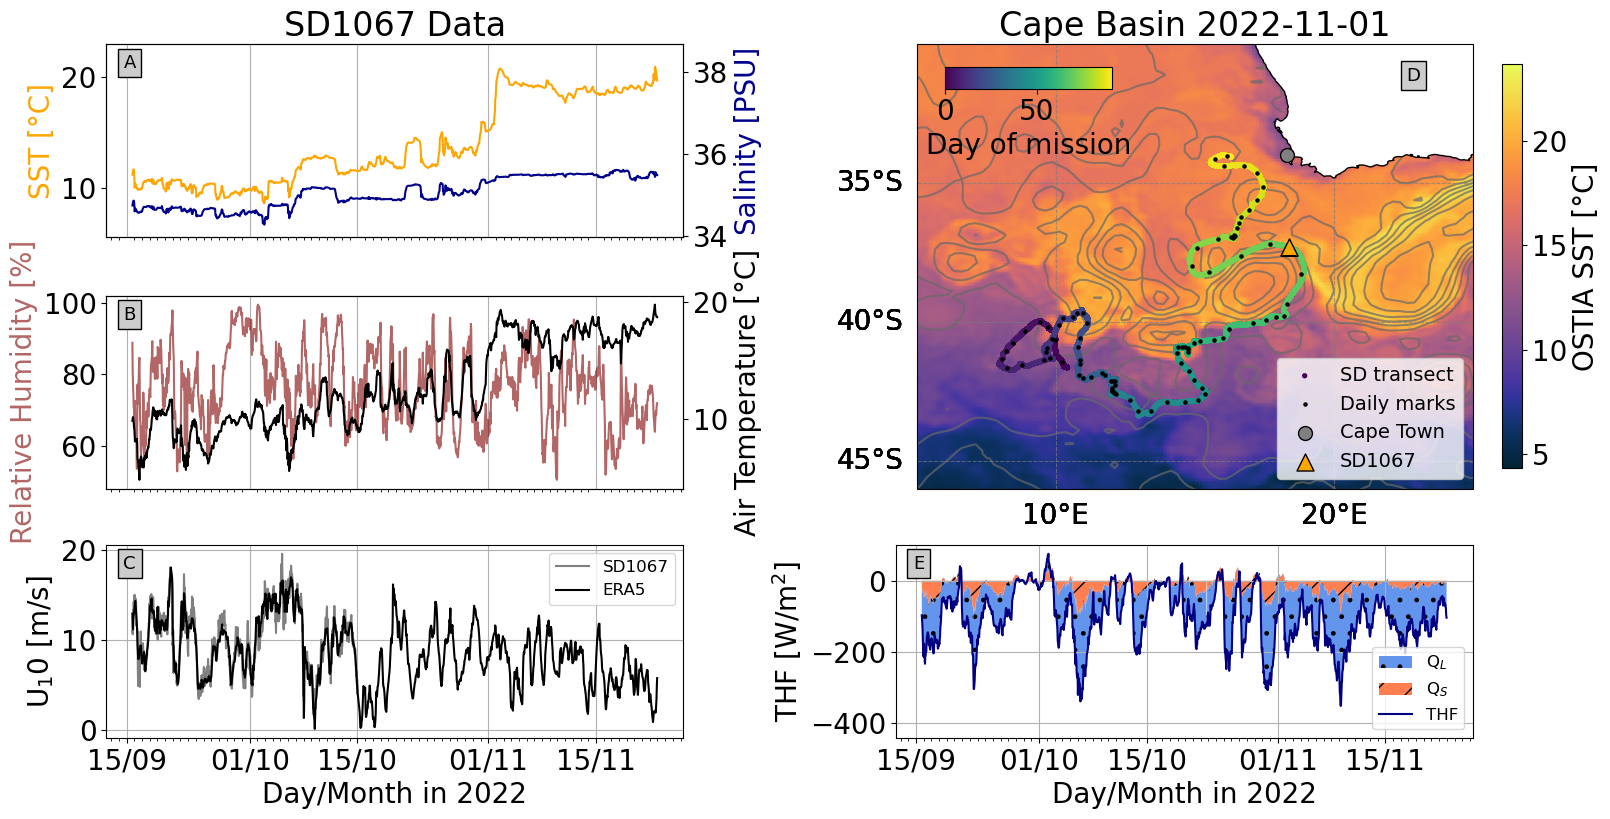

In [7]:
from matplotlib.gridspec import GridSpec
import gsw

#def format_axes(fig):
#    for i, ax in enumerate(fig.axes):
#        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
#        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=[16,10], layout="constrained")
gs = GridSpec(4, 4, figure=fig)

#####################SST & SAL####################################
ax1 = fig.add_subplot(gs[0, 0:2])

tmin=dsadcpH.sst.min()-3
tmax=dsadcpH.sst.max()+2
smin=dsadcpH.SAL_SBE37_MEAN.min()-0.3
smax=dsadcpH.SAL_SBE37_MEAN.max()

beta= gsw.beta(gsw.SA_from_SP(dsadcpH.SAL_SBE37_MEAN, 0, 15, -36), dsadcpH.sst, 0).mean()
alpha= gsw.alpha(dsadcpH.SAL_SBE37_MEAN, dsadcpH.sst, 0).mean()
deltaT=(beta/alpha)*(smax-smin)
deltaS=(alpha/beta)*(tmax-tmin)


ax1.plot(dsadcpH.time, dsadcpH.sst, c='orange')
ax1.set_ylabel('SST [°C]', c='orange')
ax1.set_ylim(tmin, tmax)

sal=ax1.twinx()
sal.plot(dsadcpH.time, dsadcpH.SAL_SBE37_MEAN, c='darkblue')
sal.set_ylim([smin, smin+deltaS ])
sal.set_ylabel('Salinity [PSU]', c='darkblue')

ax1.set_title('SD1067 Data')

###################RH & AT#####################################
ax2 = fig.add_subplot(gs[1, 0:2])
ax2.plot(dsadcpH.time, dsadcpH.rh, c='maroon', alpha=0.6)
ax2.set_ylabel('Relative Humidity [%]', c='maroon', alpha=0.6)

T2=ax2.twinx()
T2.plot(dsadcpH.time, dsadcpH.t2m, c='k')

T2.set_ylabel('Air Temperature [°C]', c='k')

#############MAP###########################
ax3 = fig.add_subplot(gs[0:2, 2:4], projection=ccrs.PlateCarree())
ticksize=12
cax = ax3.inset_axes([0.05, 0.9, 0.3, 0.05])

cbar=ax3.scatter(ds.longitude, ds.latitude, s=8, label='SD transect', c=ds.doc, zorder=4)#, alpha=0.2)
plt.colorbar(cbar, cax=cax, label='Day of mission', orientation='horizontal')
#cbar.ax.tick_params(labelsize=ticksize)


ax3.scatter(dsD.longitude, dsD.latitude, c='k', s=5, label='Daily marks', zorder=5)
#ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='dimgray', zorder=1, levels=20, alpha=0.7)
ax3.scatter(18.3, -34, c='grey', marker='o', s=100, edgecolor='k', label='Cape Town', zorder=4)
time=1125
ax3.scatter(dsadcpH.longitude.isel(time=time), dsadcpH.latitude.isel(time=time), c='orange', marker='^', s=150, edgecolor='k', label='SD1067', zorder=8)

ax3.set_title('Cape Basin 2022-11-01')

ax3.set_xlim(ostia.longitude.min()+5, ostia.longitude.max()-5)
ax3.set_ylim(ostia.latitude.min(), ostia.latitude.max())

#cax = ax3.inset_axes([0.8, 0.1, 0.05, 1.2])
cbar=ax3.pcolormesh(ostia.longitude, ostia.latitude, ostia.sst.isel(time=time)-273.15, cmap=cmo.cm.thermal)
plt.colorbar(cbar, ax=ax3, label='OSTIA SST [°C]', orientation='vertical', fraction=0.035)
ax3.contour(SSH.longitude, SSH.latitude, SSH.isel(time=61).adt, colors='dimgray', zorder=1, levels=20, alpha=0.7)


for k,spine in ax3.spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax3,10,5, True, True)
ax3.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

ax3.legend(loc='lower right', fontsize=14)

##################WIND##########################


ax4 = fig.add_subplot(gs[2, 0:2])

ax4.plot(dsadcpH.time, dsadcpH.WIND_CORR10, c='grey', label='SD1067')
ax4.plot(dsadcpH.time, coloc3.WIND_CORR10, c='k', label='ERA5')
ax4.set_ylabel('U$_10$ [m/s]', c='k')
ax4.grid()
ax4.legend(loc='upper right', fontsize=12)

ax4.set_xlabel('Day/Month in 2022')

####################FLUXES############################

ax5 = fig.add_subplot(gs[2, 2:4])
ax5.fill_between(dsadcpH.time,  SD_ASFC.sensible+SD_ASFC.latent, SD_ASFC.sensible,  hatch='.', fc='cornflowerblue', label='Q$_L$')
ax5.fill_between(dsadcpH.time,SD_ASFC.sensible, hatch='/', fc='coral', label='Q$_S$')
ax5.plot(dsadcpH.time, SD_ASFC.sensible+SD_ASFC.latent, c='navy', label='THF')
ax5.set_ylabel('THF [W/m$^2$]')
ax5.set_ylim(-440,100)

ax5.legend(fontsize=12)
ax5.grid()
ax5.set_xlabel('Day/Month in 2022')

#################################

#fig.suptitle("GridSpec")
#format_axes(fig)

ax2.sharex(ax5)
ax4.sharex(ax5)
ax1.sharex(ax5)

#ax1.set_xticklabels('')

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%d'+'/'+'%m')
ax5.xaxis.set_major_formatter(myFmt)

ax1.grid(axis='x')
ax2.grid(axis='x')
ax1.tick_params(axis='x', colors='w')
ax2.tick_params(axis='x', colors='w')
#ax1.axes.get_xaxis().set_visible(False)
#ax2.axes.get_xaxis().set_visible(False)

bbox = dict(boxstyle="square", fc="0.8")

x=0.03
y=0.95
ax1.annotate('A', xy=(x, y), xycoords='axes fraction', bbox=bbox, va='top',fontsize=13)
ax2.annotate('B', xy=(x, y), xycoords='axes fraction', bbox=bbox, va='top',fontsize=13)
ax4.annotate('C', xy=(x, y), xycoords='axes fraction', bbox=bbox, va='top',fontsize=13)
ax5.annotate('E', xy=(x, y), xycoords='axes fraction', bbox=bbox, va='top',fontsize=13)

ax3.annotate('D', xy=(x+0.85, y), xycoords='axes fraction', bbox=bbox, va='top',fontsize=13)

ax1.xaxis.set_minor_locator(mdates.DayLocator())

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/SD_overview.png')

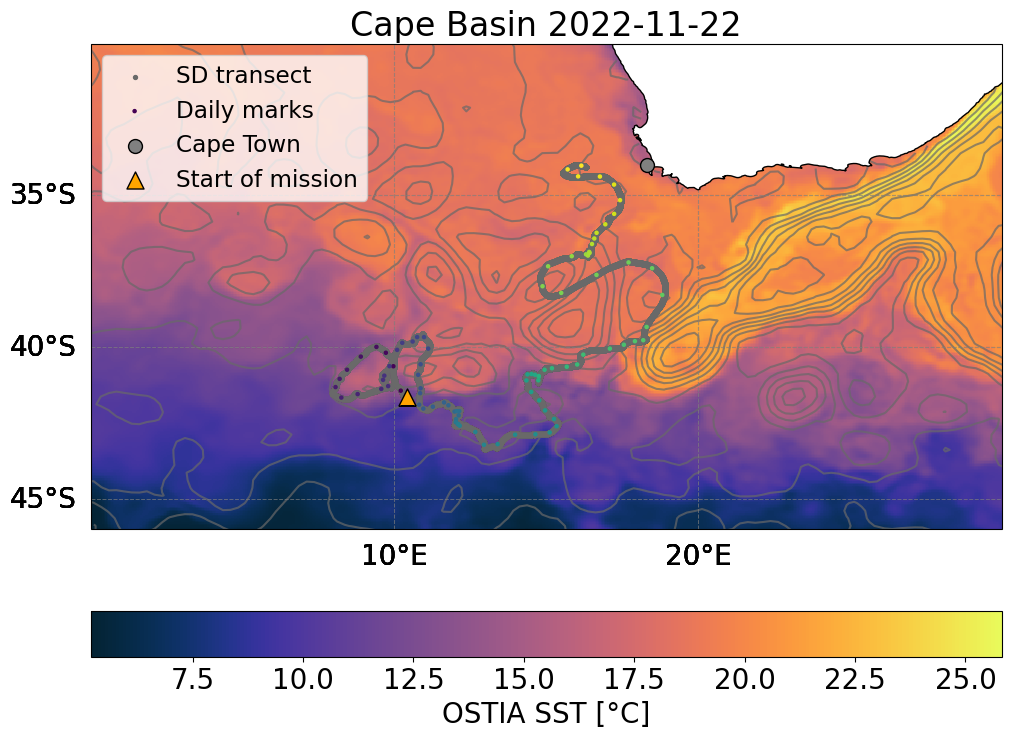

In [42]:
fig, ax=plt.subplots(figsize=[10,9],subplot_kw={'projection':ccrs.PlateCarree()}, constrained_layout=True)

cbar=ax.pcolormesh(ostia.longitude, ostia.latitude, ostia.sst.isel(time=1625)-273.15, cmap=cmo.cm.thermal)
plt.colorbar(cbar,ax=ax, label='OSTIA SST [°C]', orientation='horizontal')

ax.scatter(ds.longitude, ds.latitude, s=8, label='SD transect', c='dimgrey', zorder=4)#, alpha=0.2)
ax.scatter(dsD.longitude, dsD.latitude, c=dsD.time, s=5, label='Daily marks', zorder=5)
ax.contour(SSH.longitude, SSH.latitude, SSH.isel(time=82).adt, colors='dimgray', zorder=1, levels=20, alpha=0.7)

#plt.contour(gebco.lon, gebco.lat, gebco.elevation,levels=[0], colors='k')

ax.set_xlabel('Longitude [°E]')
ax.set_ylabel('Latitude [°N]')

ax.scatter(18.3, -34, c='grey', marker='o', s=100, edgecolor='k', label='Cape Town', zorder=4)

ax.scatter(ds.longitude.isel(time=0), ds.latitude.isel(time=0), c='orange', marker='^', s=150, edgecolor='k', label='Start of mission', zorder=4)
#plt.scatter(ds.longitude.sel(time=ds.time.max()), ds.latitude.sel(time=ds.time.max()), c='r', marker='*', s=300, edgecolor='k')#, label='End of mission')

ax.set_xlim(ostia.longitude.min(), ostia.longitude.max())
ax.set_ylim(ostia.latitude.min(), ostia.latitude.max())
ax.legend(fontsize='small', loc='upper left')

ax.set_title('Cape Basin 2022-11-22')

ax.grid(alpha=0.3)

for k,spine in ax.spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax,10,5, True, True)


ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

plt.savefig(pathlib.Path('.').absolute().parent/'MTmichaela/final_figs/area.png')

# 8.2 Upscaling

Write code for create mean and fluc variables, for-loop per day. Input in a ds, plot for each tays with fluctuations and create animation

ostia sst input data?

# CAREFUL TO RUN NEXT CELLS IF NOT NECESSARY, VERY TIME CONSUMING

## For loop, run to create anomaly and bar grid for ERA5 data.

In [ ]:
time=1001
Nx=500 #Length of x
Nz=100 #height of z


xmax=Nx #number of points in x
xmin=0

zmax=Nz #number of points in z
zmin=0


arr= np.zeros((Nz, Nx, time))

plume=xr.DataArray(arr.copy(),dims=('z','x','time')) #km, m
#plume[19:21,0:3,:]=1 #Set initial plume

plume['x']=np.linspace(xmin,xmax,Nx)
plume['z']=np.linspace(zmin,zmax,Nz)

arr= np.zeros((Nz, Nx))

S1=xr.DataArray(arr.copy(),dims=('z','x')) #km, m

S1[40:45,30:45]=1 #Set initial plume for all n,# no need to add Source in for-loop
#plume['z']=xr.DataArray=(np.linspace(zmin,zmax,Nz), dims='z')

In [ ]:
S=S1.copy().values
plume1=plume[:,:,:].copy().values

for n in tqdm(np.arange(0,len(plume.time)-1)): #time

    for i in np.arange(1,len(plume.x)-1): #x
        for j in np.arange(1, len(plume.z)-1): #z
            
            new=(S[j,i]
                +D[j]*((plume1[j,i-1,n]-2*plume1[j,i,n]+plume1[j,i+1,n])/dx**2) #diffusion x-direction
            +D[j]*((plume1[j-1,i,n]-2*plume1[j,i,n]+plume1[j+1,i,n])/dz**2) #diffusion z-direction
            -U[j]*(-plume1[j,i-1,n]+plume1[j,i,n])/dx) #advection in x with upstream wind
          #  -W[i]*(-plume1[j-1,i,n]+plume1[j,i,n])/dz) #Advection in z, just to test, not successful
             #Source added here #source already added in plume array to avoid a extra step in for-loop
           
            plume1[j,i,n+1]=plume1[j,i,n]+new*dt #add new values times dt to next timestep 
            #print(plume[j,i,n].values)   

In [ ]:
plume= xr.DataArray(plume1, 
coords={'z': plume.z,'x': plume.x,'time': plume.time}, 
dims=["z", "x", "time"])

In [8]:
ERA5big.isel(latitude=1, longitude=1)

<xarray.Dataset>
Dimensions:      (time: 1638)
Coordinates:
    longitude    float32 0.25
    latitude     float32 -30.25
  * time         (time) datetime64[ns] 2022-09-15T18:00:00 ... 2022-11-22T23:...
Data variables: (12/15)
    u10          (time) float32 ...
    v10          (time) float32 ...
    d2m          (time) float32 ...
    t2m          (time) float32 ...
    P_SEA        (time) float32 ...
    dwlw         (time) float32 ...
    ...           ...
    mslhf        (time) float32 ...
    msshf        (time) float32 ...
    sst          (time) float32 ...
    skt          (time) float32 ...
    WIND_CORR10  (time) float32 ...
    rh           (time) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-09 13:22:35 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [9]:
rec_ds=ERA5big.copy().drop(['u10','v10','d2m','t2m','P_SEA','dwlw','dwsw','msdwswrfcs','mslhf','msshf','sst','WIND_CORR10','rh','msdwlwrfcs','skt'])
arr = np.ndarray(ERA5big.sst.shape) * np.nan

rec_ds['t_term']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['u_term_t']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['q_term']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['u_term_q']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_coeffs']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_coeffs']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['cov_term_t']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['cov_term_q']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_fluc']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_fluc']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_mean']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_mean']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_recomposed']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_recomposed']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))

rec_ds['q_bar']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['T_bar']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))

In [27]:
for i in tqdm(np.arange(len(ERA5big.latitude))):
    
    for tt in np.arange(len(ERA5big.longitude)):
        e5=ERA5big.isel(latitude=i, longitude=tt)

        lat=e5.latitude.values
        lon=e5.longitude.values
        SST= e5.skt.values #e5.sst.values #ostia.sel(latitude=lat, longitude=lon, method='nearest').sst.values
        
#        if  np.isfinite(SST.mean()):
        hum1=e5.rh.values
        
        spd= e5.WIND_CORR10.values#relative windpeed
        T= e5.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
        hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
        P= e5.P_SEA.values #air pressure in hPA
        SST_fl ='skin' #string, 'bulk' or 'skin' for input
        meth= 'C35' #string, choose method of calcultion
        lat= np.zeros(len(spd))+e5.latitude.values #latitude
        hin=([10, 2, 2])  #sensor heights in m, 3x1 same order as output 
        hout=10 #output height, default is 10m
        Rl=e5.dwlw.values#longwave dwn radiation
        Rs= e5.dwsw.values # shortwave dwn radiation
        cskin= 0 #0 cool skin adj off
        skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
        wl=0 #warm layer off 0 (default)
        gust= None# [x,beta,zi,ustbj] #Check documentation
        qmeth= 'Buck2' #string, saturation evaporation method
        tol= None #float, tolerance limits for fluxes and heights, check documentation
        maxiter= 30 #number fo iterations
        out= 1 #int, set 0 to set points thathave not converged
        out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
        L=None #str, M-O definition option. 'tsrv' is default
        
        ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                           hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                           gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                           out_var=out_var, L=L)
        
        u = ASFC.uref #ASFC['usr']/np.sqrt(ASFC['cd'])
        t = ASFC['tsr']*np.sqrt(ASFC['cd'])/ASFC['ct']
        rho = ASFC['rho']
        cp = ASFC['cp']
        ct = ASFC['ct']
        lv = ASFC['lv']
        q = ASFC['qsr']*np.sqrt(ASFC['cd'])/ASFC['cq']
        cq= ASFC['cq']
        
        u_mean = np.mean(u)
        t_mean = np.mean(t)
        q_mean = np.mean(q)
        
        u_fluc = u - u_mean
        t_fluc = t - t_mean
        q_fluc = q - q_mean
        
        
        t_term = u_mean*t_fluc
        u_term_t = t_mean*u_fluc
        q_term = u_mean*q_fluc
        u_term_q = q_mean*u_fluc
        
        #lhf_coeffs=rho*cq*lv
        #shf_coeffs=rho*cp*ct
        
        lhf_coeffs=rho.mean()*cq.mean()*lv.mean()
        shf_coeffs=rho.mean()*cp.mean()*ct.mean()
        
        cov_term_t = u_fluc*t_fluc - np.mean(u_fluc*t_fluc)
        cov_term_q = u_fluc*q_fluc - np.mean(u_fluc*q_fluc)
        
        lhf_fluc = lhf_coeffs*(q_term + u_term_q + cov_term_q) 
        shf_fluc = shf_coeffs*(t_term + u_term_t + cov_term_t) 
        
        lhf_mean = np.zeros(len(q))+np.nanmean(q*u)*lhf_coeffs #np.mean(ASFC['latent'])
        shf_mean = np.zeros(len(q))+np.nanmean(t*u)*shf_coeffs #np.mean(ASFC['sensible'])
        
        lhf_recomposed = lhf_mean + lhf_fluc
        shf_recomposed = shf_mean + shf_fluc
        
        
        #variables=['t_term', 'u_term_t', 'q_term', 'u_term_q','lhf_coeffs', 'shf_coeffs', 'cov_term_t', 'cov_term_q', 'lhf_fluc', 'shf_fluc', 'lhf_mean', 'shf_mean', 'lhf_recomposed','shf_recomposed' ]

        
        # ERA5bigtest['new_var'] = xr.DataArray(arr,dims=('time','latitude','longitude'))
        rec_ds['t_term'][:,i,tt]=shf_coeffs* t_term
        rec_ds['u_term_t'][:,i,tt]= shf_coeffs* u_term_t
        rec_ds['q_term'][:,i,tt]= lhf_coeffs*q_term
        rec_ds['u_term_q'][:,i,tt]= lhf_coeffs*u_term_q
        rec_ds['lhf_coeffs'][:,i,tt]= lhf_coeffs
        rec_ds['shf_coeffs'][:,i,tt]= shf_coeffs
        rec_ds['cov_term_t'][:,i,tt]= shf_coeffs* cov_term_t
        rec_ds['cov_term_q'][:,i,tt]=lhf_coeffs*cov_term_q
        rec_ds['lhf_fluc'][:,i,tt]= lhf_fluc
        rec_ds['shf_fluc'][:,i,tt]=shf_fluc
        rec_ds['lhf_mean'][:,i,tt]=lhf_mean 
        rec_ds['shf_mean'][:,i,tt]=shf_mean
        rec_ds['lhf_recomposed'][:,i,tt]=lhf_recomposed 
        rec_ds['shf_recomposed'][:,i,tt]=shf_recomposed 
        rec_ds['q_bar'][:,i,tt]=q_mean
        rec_ds['T_bar'][:,i,tt]=t_mean

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [06:29<00:00,  5.99s/it]


In [29]:
rec_ds.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_out_1.nc')

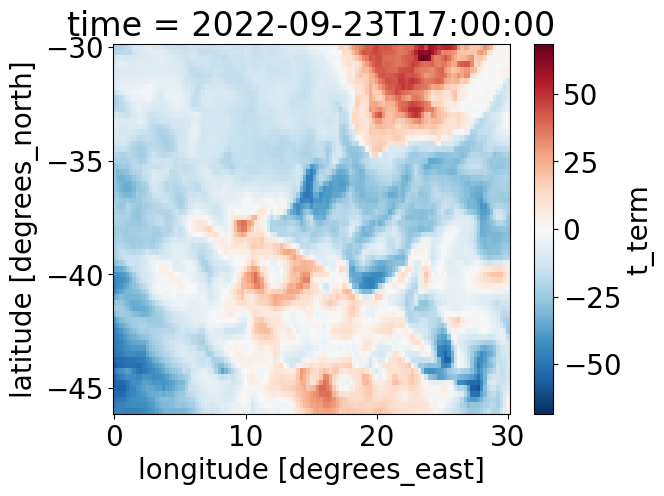

In [28]:
rec_ds.isel(time=191).t_term.plot()

#  IF FOR-LOOP NOT NECESSARY START HERE

Packages & fns for upscale

In [30]:
import scipy.io
import mat73
import glob 
import datetime

def plot_eddies(eddies, ax):
    
    for eddy in range(np.shape(np.array(eddies['Anticyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Anticyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Anticyclonic_Cell'][eddy][5]

        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3)
       
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='r', lw=0.5, zorder=3, label='Anticyclonic cell')
        
#         eddy_in_lon = eddies['Anticyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Anticyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='r', ls='--', lw=1)
        
    for eddy in range(np.shape(np.array(eddies['Cyclonic_Cell'], dtype=object))[0]):
        
        eddy_out_lon = eddies['Cyclonic_Cell'][eddy][4]
        eddy_out_lat = eddies['Cyclonic_Cell'][eddy][5]
    
        ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3)
    ax.plot(eddy_out_lon, eddy_out_lat, transform=ccrs.PlateCarree(), c='b', lw=0.5, zorder=3, label='Cyclonic cell')   
    
#         eddy_in_lon = eddies['Cyclonic_Cell'][eddy][8]
#         eddy_in_lat = eddies['Cyclonic_Cell'][eddy][9]
  
#         ax.plot(eddy_in_lon, eddy_in_lat, transform=ccrs.PlateCarree(), c='b', ls='--', lw=1)



import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.ticker as mticker

def gridlines(ax,lon_tick,lat_tick, ToF_bottom, ToF_left):
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      x_inline=False, y_inline=False,
                      linewidth=0.75, alpha=0.5, linestyle='--',color='w',
                      ylocs = mpl.ticker.MultipleLocator(base=lat_tick),xlocs = mpl.ticker.MultipleLocator(base=lon_tick))
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlocator = mticker.FixedLocator([0, 10, 20, 30])
    
    gl.xpadding=10
    gl.ypadding=10
    gl.bottom_labels = ToF_bottom
    gl.left_labels = ToF_left


### Open contour datasets for eddies

In [5]:
files = sorted(glob.glob(os.getcwd()+'/../MTmichaela/MasterH23/eddies/adt*.mat'))

eddy_files = files

In [26]:
eddies=[]
for fname in tqdm(eddy_files):
    
    # load eddy file for the day
    
    eddies.append(mat73.loadmat(fname))
    
    # define the date of the eddy file
    
#    d = eddies['date_num']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:33<00:00,  2.08it/s]


### Open reconstructed dataset that was created with for-loop, ERA5 data

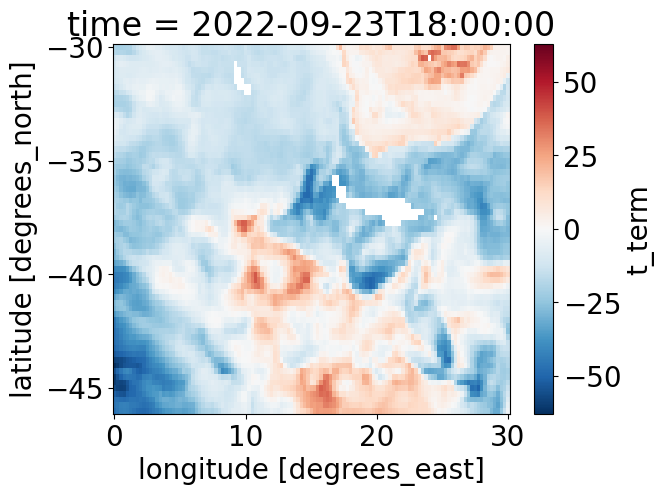

In [18]:
rec_ds_ERA5.isel(time=192).t_term.plot()

In [22]:
rec_ds_ERA5.isel(time=192).t_term.sel(longitude=20, latitude=-37).values

array(nan)

In [23]:
e5=ERA5big.sel(latitude=-37, longitude=20)

lat=e5.latitude.values
lon=e5.longitude.values
SST= e5.skt.values #e5.sst.values #ostia.sel(latitude=lat, longitude=lon, method='nearest').sst.values

#        if  np.isfinite(SST.mean()):
hum1=e5.rh.values

spd= e5.WIND_CORR10.values#relative windpeed
T= e5.t2m.values #seasurface temperature in kelvin. Will convert iff less than 200
hum= ['rh', hum1 ] #chose rh, spec hum or dew point temp.
P= e5.P_SEA.values #air pressure in hPA
SST_fl ='skin' #string, 'bulk' or 'skin' for input
meth= 'C35' #string, choose method of calcultion
lat= np.zeros(len(spd))+e5.latitude.values #latitude
hin=([10, 2, 2])  #sensor heights in m, 3x1 same order as output 
hout=10 #output height, default is 10m
Rl=e5.dwlw.values#longwave dwn radiation
Rs= e5.dwsw.values # shortwave dwn radiation
cskin= 0 #0 cool skin adj off
skin='C35' #'C35' #string "C35", "ecmwf" or "Beljaars"
wl=0 #warm layer off 0 (default)
gust= None# [x,beta,zi,ustbj] #Check documentation
qmeth= 'Buck2' #string, saturation evaporation method
tol= None #float, tolerance limits for fluxes and heights, check documentation
maxiter= 30 #number fo iterations
out= 0 #int, set 0 to set points thathave not converged
out_var= None #str, define pandas arrayod variables for output. There i a default for cskin and gust off. Check documentation
L=None #str, M-O definition option. 'tsrv' is default

ASFC=AirSeaFluxCode(spd, T, SST, SST_fl, meth, lat=lat, hum=hum, P=P,
                   hin=hin, hout=hout, Rl=Rl, Rs=Rs, cskin=cskin, skin=skin, wl=wl,
                   gust=gust, qmeth=qmeth, tol=tol, maxiter=maxiter, out=out,
                   out_var=out_var, L=L)

In [35]:
u = ASFC.uref #ASFC['usr']/np.sqrt(ASFC['cd'])
t = ASFC['tsr']*np.sqrt(ASFC['cd'])/ASFC['ct']
rho = ASFC['rho']
cp = ASFC['cp']
ct = ASFC['ct']
lv = ASFC['lv']
q = ASFC['qsr']*np.sqrt(ASFC['cd'])/ASFC['cq']
cq= ASFC['cq']

u_mean = np.mean(u)
t_mean = np.mean(t)
q_mean = np.mean(q)

u_fluc = u - u_mean
t_fluc = t - t_mean
q_fluc = q - q_mean


t_term = u_mean*t_fluc
u_term_t = t_mean*u_fluc
q_term = u_mean*q_fluc
u_term_q = q_mean*u_fluc

#lhf_coeffs=rho*cq*lv
#shf_coeffs=rho*cp*ct

lhf_coeffs=rho.mean()*cq.mean()*lv.mean()
shf_coeffs=rho.mean()*cp.mean()*ct.mean()

cov_term_t = u_fluc*t_fluc - np.mean(u_fluc*t_fluc)
cov_term_q = u_fluc*q_fluc - np.mean(u_fluc*q_fluc)

lhf_fluc = lhf_coeffs*(q_term + u_term_q + cov_term_q) 
shf_fluc = shf_coeffs*(t_term + u_term_t + cov_term_t) 

lhf_mean = np.zeros(len(q))+np.nanmean(q*u)*lhf_coeffs #np.mean(ASFC['latent'])
shf_mean = np.zeros(len(q))+np.nanmean(t*u)*shf_coeffs #np.mean(ASFC['sensible'])

lhf_recomposed = lhf_mean + lhf_fluc
shf_recomposed = shf_mean + shf_fluc

In [86]:
hum1[191]

45.340954

In [40]:
t_term[191]
t_fluc[191]
t[191]
ASFC['tsr'][191]
ASFC['ct'][191]
ASFC['cd'][191]
u[191]

nan

In [84]:
#pd.set_option('display.max_rows', None)
#pd.reset_option('all')

In [46]:
#rec_ds_ostia_coloc=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleOSTIA_coloc.nc')
rec_ds_ERA5=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5.nc')
#rec_ds_ostia_regrid=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleOSTIA_regrid.nc')

In [47]:
def plot_upscale(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'),ssh_plot=1, eddy_plot=0, ani_fig_save=0, figsize=[29,12]):
    
    fig, ax=plt.subplots(2,4, figsize=figsize, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    
    
    ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    
    ax[0,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    ax[0,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    cbar_s=ax[0,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    #plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')
    
    
    ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    cbar_l=ax[1,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    
    cax = ax[1,3].inset_axes([0, -0.3, 0.9, 0.1])
    cbar=fig.colorbar(cbar_l, cax=cax, label=('Contribution to Q$^\prime$ [W/m$^2$] '), orientation='horizontal')
    
    cbar.ax.tick_params(labelsize=20)
    
    
    #plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')
    
    
    ax[0,0].set_title('Q$^\prime$$_S$')
    ax[0,0+1].set_title('T$_S$-term')
    ax[0,1+1].set_title('U$_S$-term')
    ax[0,2+1].set_title('C$_S$-term')
    
    ax[1,0].set_title('Q$^\prime$$_L$')
    ax[1,0+1].set_title('q$_L$-term')
    ax[1,1+1].set_title('U$_L$-term')
    ax[1,2+1].set_title('C$_L$-term')
    alpha=0.4
    
    ax[0,0].grid(alpha=alpha)
    ax[0,0+1].grid(alpha=alpha)
    ax[0,1+1].grid(alpha=alpha)
    ax[0,2+1].grid(alpha=alpha)
    
    ax[1,0].grid(alpha=alpha)
    ax[1,0+1].grid(alpha=alpha)
    ax[1,1+1].grid(alpha=alpha)
    ax[1,2+1].grid(alpha=alpha)
    
    
    ax[1,0].set_xlabel('Longitude [°E]')
    ax[1,0+1].set_xlabel('Longitude [°E]')
    ax[1,1+1].set_xlabel('Longitude [°E]')
    ax[1,2+1].set_xlabel('Longitude [°E]')
    
    ax[0,0].set_ylabel('Latitude [°N]')
    ax[1,0].set_ylabel('Latitude [°N]')
    
    
    
    fig_labels=[['A','B','C','D'],['E','F','G','H']]
    
    x=0.018
    y=1.085
    
    ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
    ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,3].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
    ToF_bottom1=[False, False, False, False]
    ToF_left1=[True, False, False, False]
    
    ToF_bottom=[True, True, True, True]
    ToF_left=[True, False, False, False]
    
    # Add land and coastline
    for i in np.arange(4):    
        ax[0,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
        ax[1,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    
        ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
        
    
        ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    
    
        
        for k,spine in ax[0,i].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[0,i],10,5, ToF_bottom1[i], ToF_left1[i])
        
        for k,spine in ax[1,i].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[1,i],10,5, ToF_bottom[i], ToF_left[i])
    
    
    
    ax[1,2].annotate((pd.to_datetime(rec_ds.time[time].values).strftime("%m/%d/%Y, %H:%M")), xy=(0.15, -0.4), xycoords='axes fraction', bbox=bbox,fontsize=25)
    
    
    ax[1,0].set_xlim(rec_ds.longitude.min(),rec_ds.longitude.max())
    ax[1,0].set_ylim(rec_ds.latitude.min(),rec_ds.latitude.max())       
    
    #EDDIES
    
    if eddy_plot == 1:
        for i in np.arange(len(eddies)):
            d = eddies[i]['date_num']
        
            py_date = np.datetime64(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d % 1) - datetime.timedelta(days=366), 'ms')
            if py_date.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(4):
                    plot_eddies(eddies[i], ax[0,frame])
                    plot_eddies(eddies[i], ax[1,frame])
                break


    if ssh_plot==1:
        for ssh in np.arange(len(SSH.time)):
            d = SSH.time.isel(time=ssh)
        
            if d.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(4):
                    ax[0,frame].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='dimgray', zorder=1, levels=10, alpha=0.7)
                    ax[1,frame].contour(SSH.longitude, SSH.latitude, SSH.isel(time=ssh).adt, colors='dimgray', zorder=1, levels=10, alpha=0.7)

    
    ax[1,1].legend(bbox_to_anchor=[0.67, -0.13], ncols=2)

    if ani_fig_save==1:
        plt.savefig(pathlib.Path('.').absolute().parent/ f'MTmichaela/ani_fig/pic_{time:04}.png')
    else:
        plt.show()
        
#    plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/test.png')
#    plt.tight_layout()

    plt.close(fig)
#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

In [48]:
time=190
vmin_l=-100
vmax_l=100

vmin_s=vmin_l
vmax_s=vmax_l
cmap='RdBu_r'

rec_ds=rec_ds_ERA5

#eddy_plot=1 #Plot eddies or not, =1 plots eddies

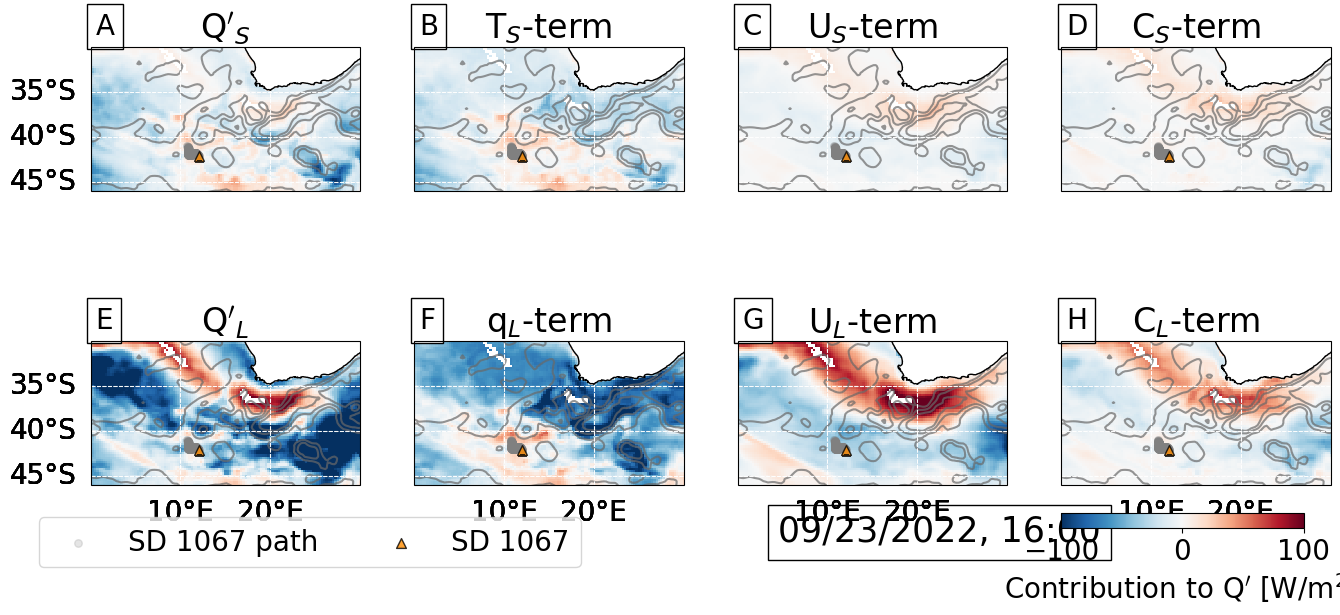

In [51]:
plot_upscale(time, vmin_l, vmax_l, vmin_s=vmin_l, vmax_s=vmax_l, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), ani_fig_save=0,ssh_plot=1, eddy_plot=0, figsize=[16,7])

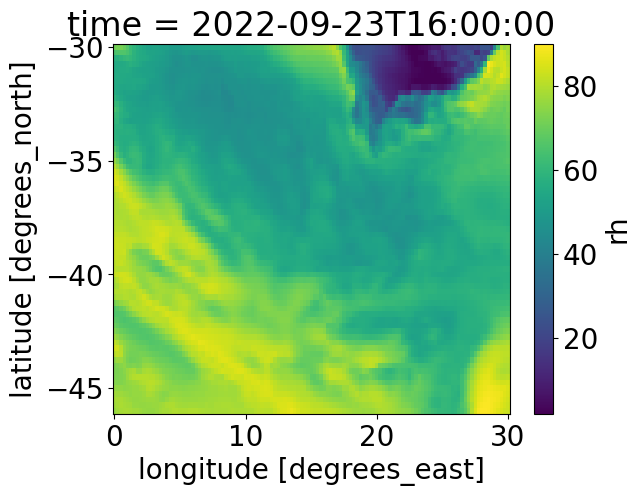

In [31]:
ERA5big.isel(time=190).rh.plot()


* Check the cyclones.mat files and att on top

In [ ]:
labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

# Be aware of next step if you dont need to re-make figures for animation

## Save figures to animate in folder

In [9]:
rec_ds=rec_ds_ERA5 #Choose dataset


for time in tqdm(np.arange(1391, len(rec_ds.time))):
    plot_upscale(time, vmin_l, vmax_l, vmin_s=vmin_l, vmax_s=vmax_l, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), ani_fig_save=1,ssh_plot=1, eddy_plot=0, figsize=[30,11])



100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 247/247 [20:33<00:00,  5.00s/it]


Create animation

In [10]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ 'MTmichaela/ani_fig'
fps=8

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('terms.mp4')

Moviepy - Building video terms.mp4.
Moviepy - Writing video terms.mp4



Moviepy - Done !
Moviepy - video ready terms.mp4


# Correlation between Q' and the terms

Open rec_r2 if not necessary to rebuild it

In [5]:
rec_r2=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2.nc')

Plot upscale corr plots

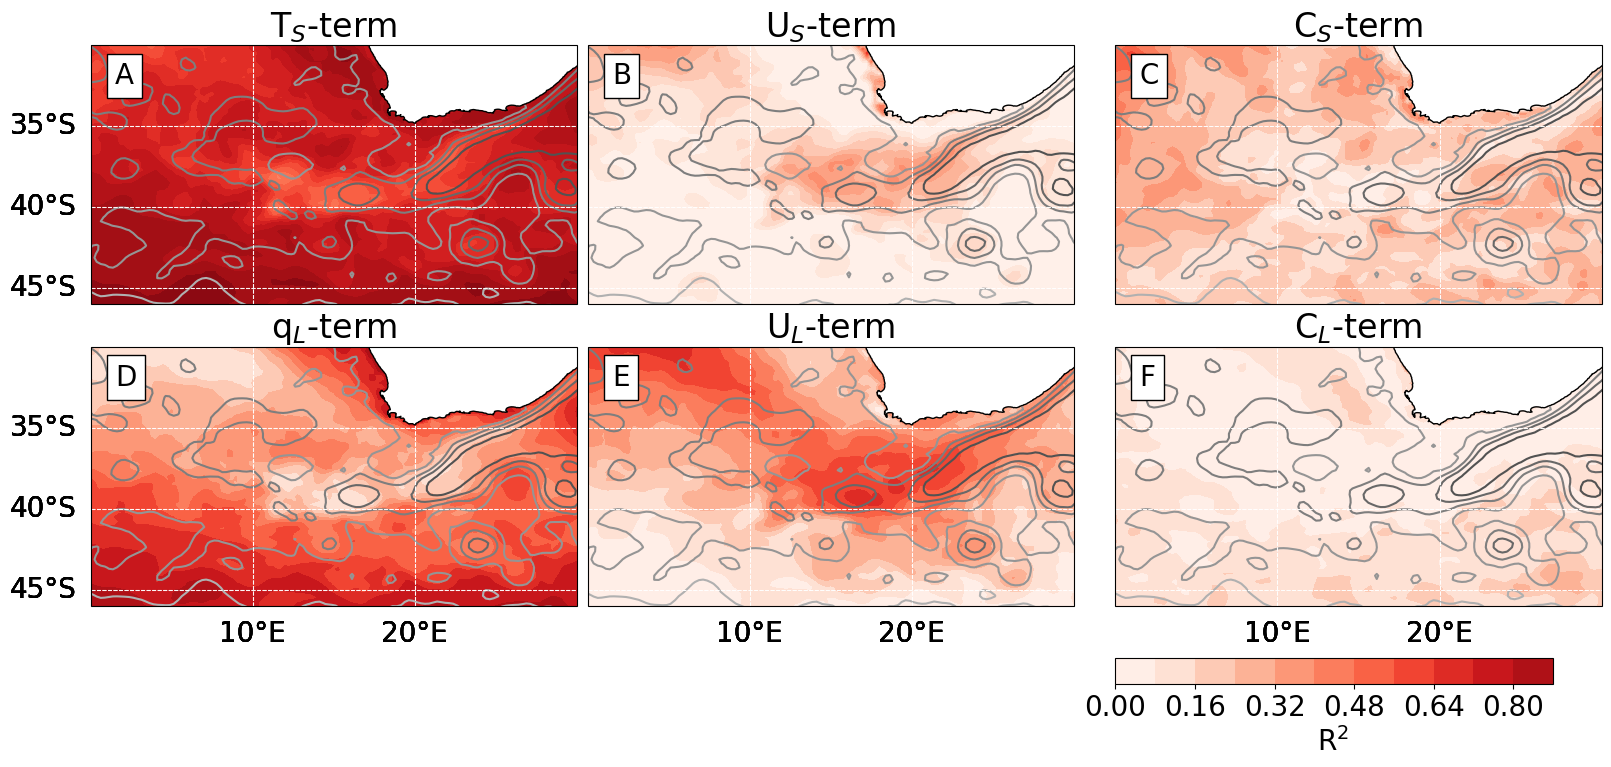

In [44]:
#time=100
vmin_l=0
vmax_l=1

vmin_s=vmin_l
vmax_s=vmax_l
cmap='Reds'
cmap2='Greys'
levels=10
levels2=10

rec_ds=rec_r2
bbox = dict(boxstyle="square", fc='w')

fig, ax=plt.subplots(2,3, figsize=[16,7.5], constrained_layout=True, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})

#ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc)#, vmin=vmin_s, vmax=vmax_s, cmap=cmap )

ax[0,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term, vmin=vmin_s, vmax=vmax_s, cmap=cmap, levels=levels )
ax[0,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap , levels=levels)
cbar_s=ax[0,2].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap, levels=levels )

#ax[0,0].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term, vmin=vmin_s, vmax=vmax_s, cmap=cmap2, levels=levels2 )
#ax[0,1].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap2 , levels=levels2)
#ax[0,2].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap2, levels=levels2 )
#plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')


#ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc)#, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,0].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )
ax[1,1].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )
cbar_l=ax[1,2].contourf(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap, levels=levels )

adt_levels=12

ax[0,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[0,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[0,2].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)

ax[1,0].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[1,1].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)
ax[1,2].contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=adt_levels)

#ax[1,0].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,1].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )
#ax[1,2].contour(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap2, levels=levels2 )


cax = ax[1,2].inset_axes([0, -0.3, 0.9, 0.1])
cbar=fig.colorbar(cbar_l, cax=cax, label=('R$^2$ '), orientation='horizontal')

cbar.ax.tick_params(labelsize=20)


#plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')


#ax[0,0].set_title('Q$^\prime$$_S$')
ax[0,0].set_title('T$_S$-term')
ax[0,1].set_title('U$_S$-term')
ax[0,2].set_title('C$_S$-term')

#ax[1,0].set_title('Q$^\prime$$_L$')
ax[1,0].set_title('q$_L$-term')
ax[1,1].set_title('U$_L$-term')
ax[1,2].set_title('C$_L$-term')
alpha=0.4

#ax[0,0].grid(alpha=alpha)
ax[0,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[0,2].grid(alpha=alpha)

#ax[1,0].grid(alpha=alpha)
ax[1,0].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
ax[1,2].grid(alpha=alpha)


#ax[1,0].set_xlabel('Longitude [°E]')
ax[1,0].set_xlabel('Longitude [°E]')
ax[1,1].set_xlabel('Longitude [°E]')
ax[1,2].set_xlabel('Longitude [°E]')

ax[0,0].set_ylabel('Latitude [°N]')
ax[1,0].set_ylabel('Latitude [°N]')



fig_labels=[['A','B','C'],['D','E','F']]

x=0.05
y=0.85

ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
#ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)

ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
#ax[1,3].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)

ToF_bottom1=[False, False, False, False]
ToF_left1=[True, False, False, False]

ToF_bottom=[True, True, True, True]
ToF_left=[True, False, False, False]

# Add land and coastline
for i in np.arange(3):    
    ax[0,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    ax[1,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

#    ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    

#    ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')


    
    for k,spine in ax[0,i].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[0,i],10,5, ToF_bottom1[i], ToF_left1[i])
    
    for k,spine in ax[1,i].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[1,i],10,5, ToF_bottom[i], ToF_left[i])

plt.xlim(ERA5big.longitude.min(), ERA5big.longitude.max())
plt.ylim(ERA5big.latitude.min(), ERA5big.latitude.max())

plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/final_figs/R2_upscale.png')
#ax[1,1].legend(bbox_to_anchor=[0.99,-0.12])


#bbox = dict(boxstyle="square", fc='w')
#ax[1,2].annotate((pd.to_datetime(rec_ds.time[i].values).strftime("%m/%d/%Y, %H:%M")), xy=(-0.15, -0.3), xycoords='axes fraction', bbox=bbox,fontsize=25)

#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

(-46.0, -30.0)

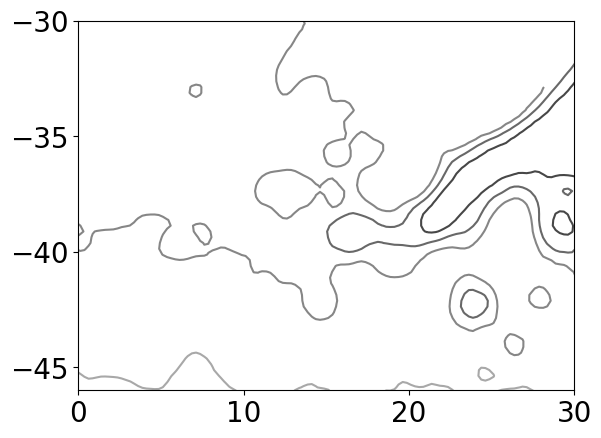

In [37]:
plt.contour(SSH.longitude,SSH.latitude, SSH.adt[15:83,:,:].mean(dim='time'), cmap='Greys', levels=10)
plt.xlim(ERA5big.longitude.min(), ERA5big.longitude.max())
plt.ylim(ERA5big.latitude.min(), ERA5big.latitude.max())

In [ ]:
SSH.adt[15:83,:,:].mean(dim='time')

## Upscale avg. terms

In [18]:
rec_avg=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscale_AVG.nc')

## Plot avg terms, double check this

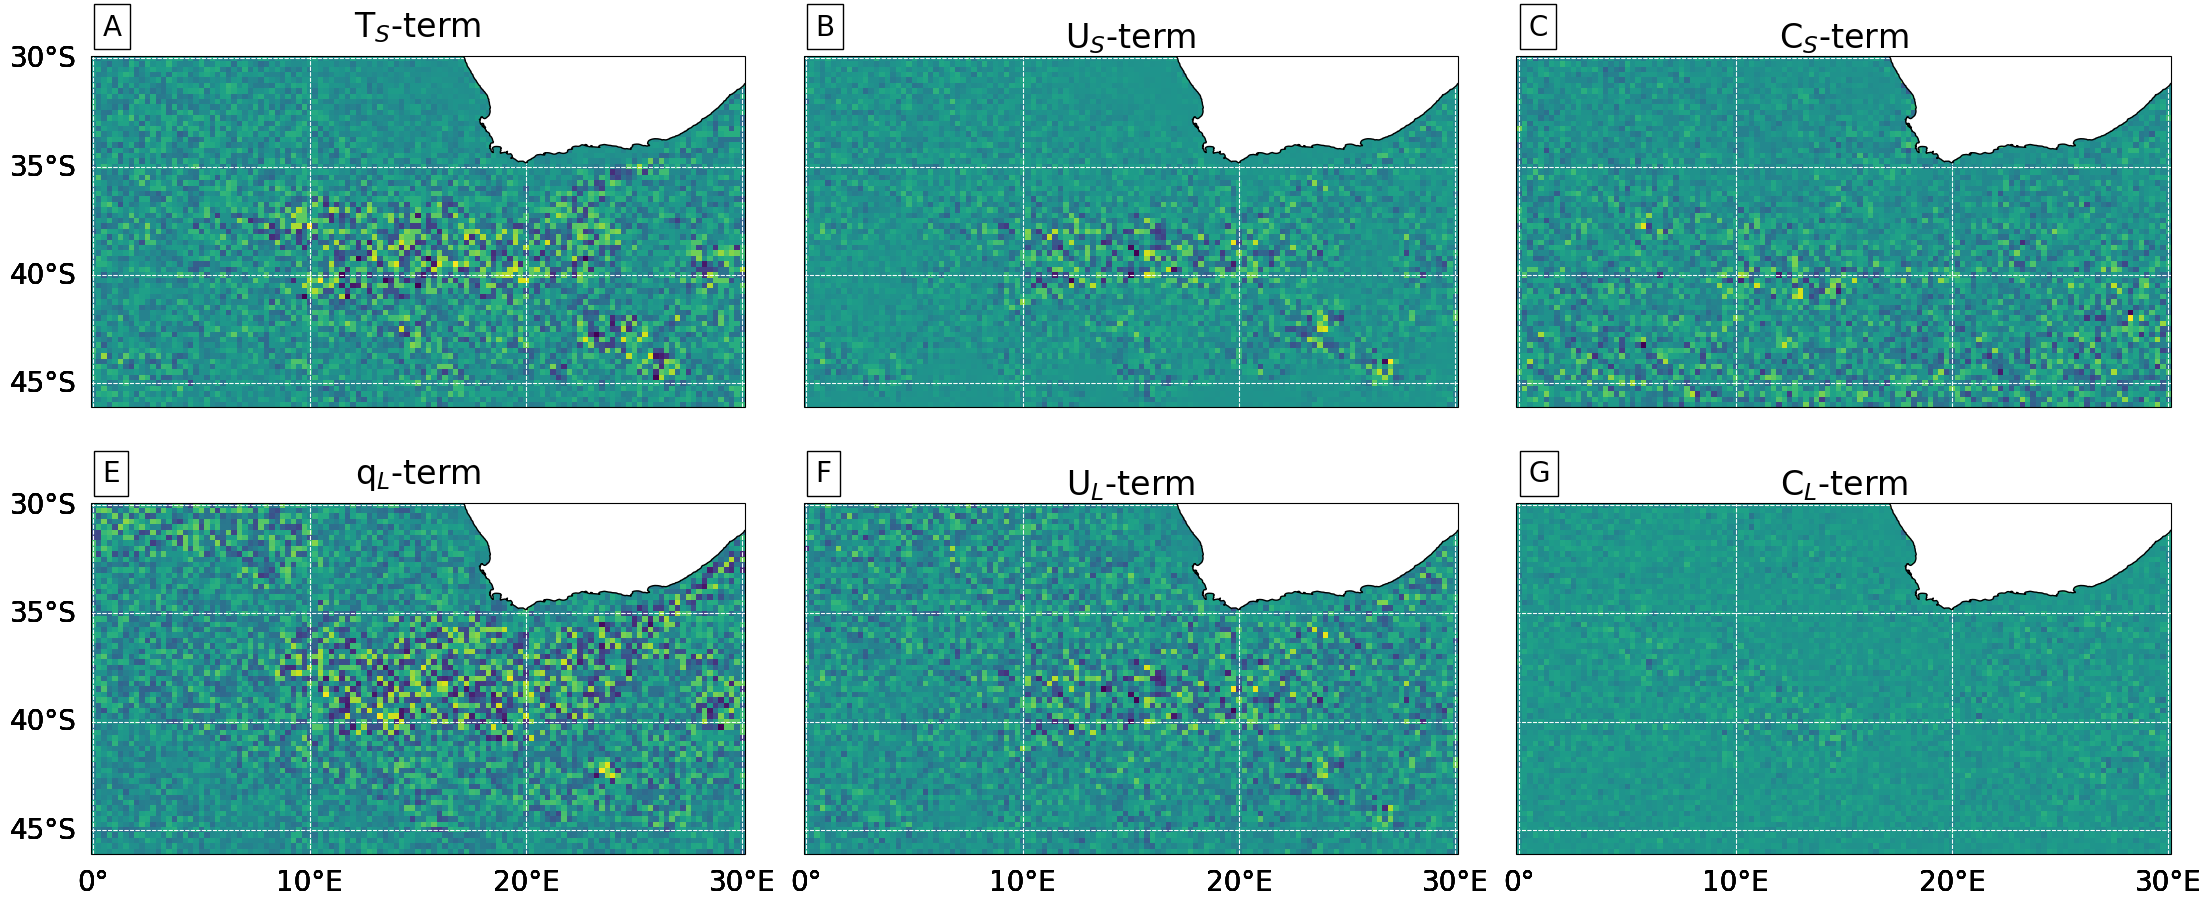

In [21]:
#time=100
bbox = dict(boxstyle="square", fc='w')
vmin_l=None #rec_ds.cov_term_q.min().values
vmax_l=None #rec_ds.cov_term_q.max().values

vmin_s=vmin_l
vmax_s=vmax_l
cmap=None

rec_ds=rec_avg


fig, ax=plt.subplots(2,3, figsize=[22,9], constrained_layout=True, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})

#ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc)#, vmin=vmin_s, vmax=vmax_s, cmap=cmap )

ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term, vmin=vmin_s, vmax=vmax_s, cmap=cmap )
ax[0,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap )
cbar_s=ax[0,2].pcolormesh(ERA5big.longitude, ERA5big.latitude,rec_ds.cov_term_t, vmin=vmin_s, vmax=vmax_s, cmap=cmap )
#plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')


#ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc)#, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude,rec_ds.q_term, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
cbar_l=ax[1,2].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q, vmin=vmin_l, vmax=vmax_l, cmap=cmap )

#cax = ax[1,2].inset_axes([0, -0.3, 0.9, 0.1])
#cbar=fig.colorbar(cbar_l, cax=cax, label=('avg '), orientation='horizontal')

#cbar.ax.tick_params(labelsize=20)


#plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')


#ax[0,0].set_title('Q$^\prime$$_S$')
ax[0,0].set_title('T$_S$-term')
ax[0,1].set_title('U$_S$-term')
ax[0,2].set_title('C$_S$-term')

#ax[1,0].set_title('Q$^\prime$$_L$')
ax[1,0].set_title('q$_L$-term')
ax[1,1].set_title('U$_L$-term')
ax[1,2].set_title('C$_L$-term')
alpha=0.4

#ax[0,0].grid(alpha=alpha)
ax[0,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[0,2].grid(alpha=alpha)

#ax[1,0].grid(alpha=alpha)
ax[1,0].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
ax[1,2].grid(alpha=alpha)


#ax[1,0].set_xlabel('Longitude [°E]')
ax[1,0].set_xlabel('Longitude [°E]')
ax[1,1].set_xlabel('Longitude [°E]')
ax[1,2].set_xlabel('Longitude [°E]')

ax[0,0].set_ylabel('Latitude [°N]')
ax[1,0].set_ylabel('Latitude [°N]')



fig_labels=[['A','B','C','D'],['E','F','G','H']]

x=0.018
y=1.06

ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
#ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)

ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
#ax[1,3].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)

ToF_bottom1=[False, False, False, False]
ToF_left1=[True, False, False, False]

ToF_bottom=[True, True, True, True]
ToF_left=[True, False, False, False]

# Add land and coastline
for i in np.arange(3):    
    ax[0,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    ax[1,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

#    ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    

#    ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')


    
    for k,spine in ax[0,i].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[0,i],10,5, ToF_bottom1[i], ToF_left1[i])
    
    for k,spine in ax[1,i].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[1,i],10,5, ToF_bottom[i], ToF_left[i])


#ax[1,1].legend(bbox_to_anchor=[0.99,-0.12])


#bbox = dict(boxstyle="square", fc='w')
#ax[1,2].annotate((pd.to_datetime(rec_ds.time[i].values).strftime("%m/%d/%Y, %H:%M")), xy=(-0.15, -0.3), xycoords='axes fraction', bbox=bbox,fontsize=25)

#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

In [29]:
np.abs(rec_ds.u_term_q).max()

<xarray.DataArray 'u_term_q' ()>
array(4.25887846e-14)

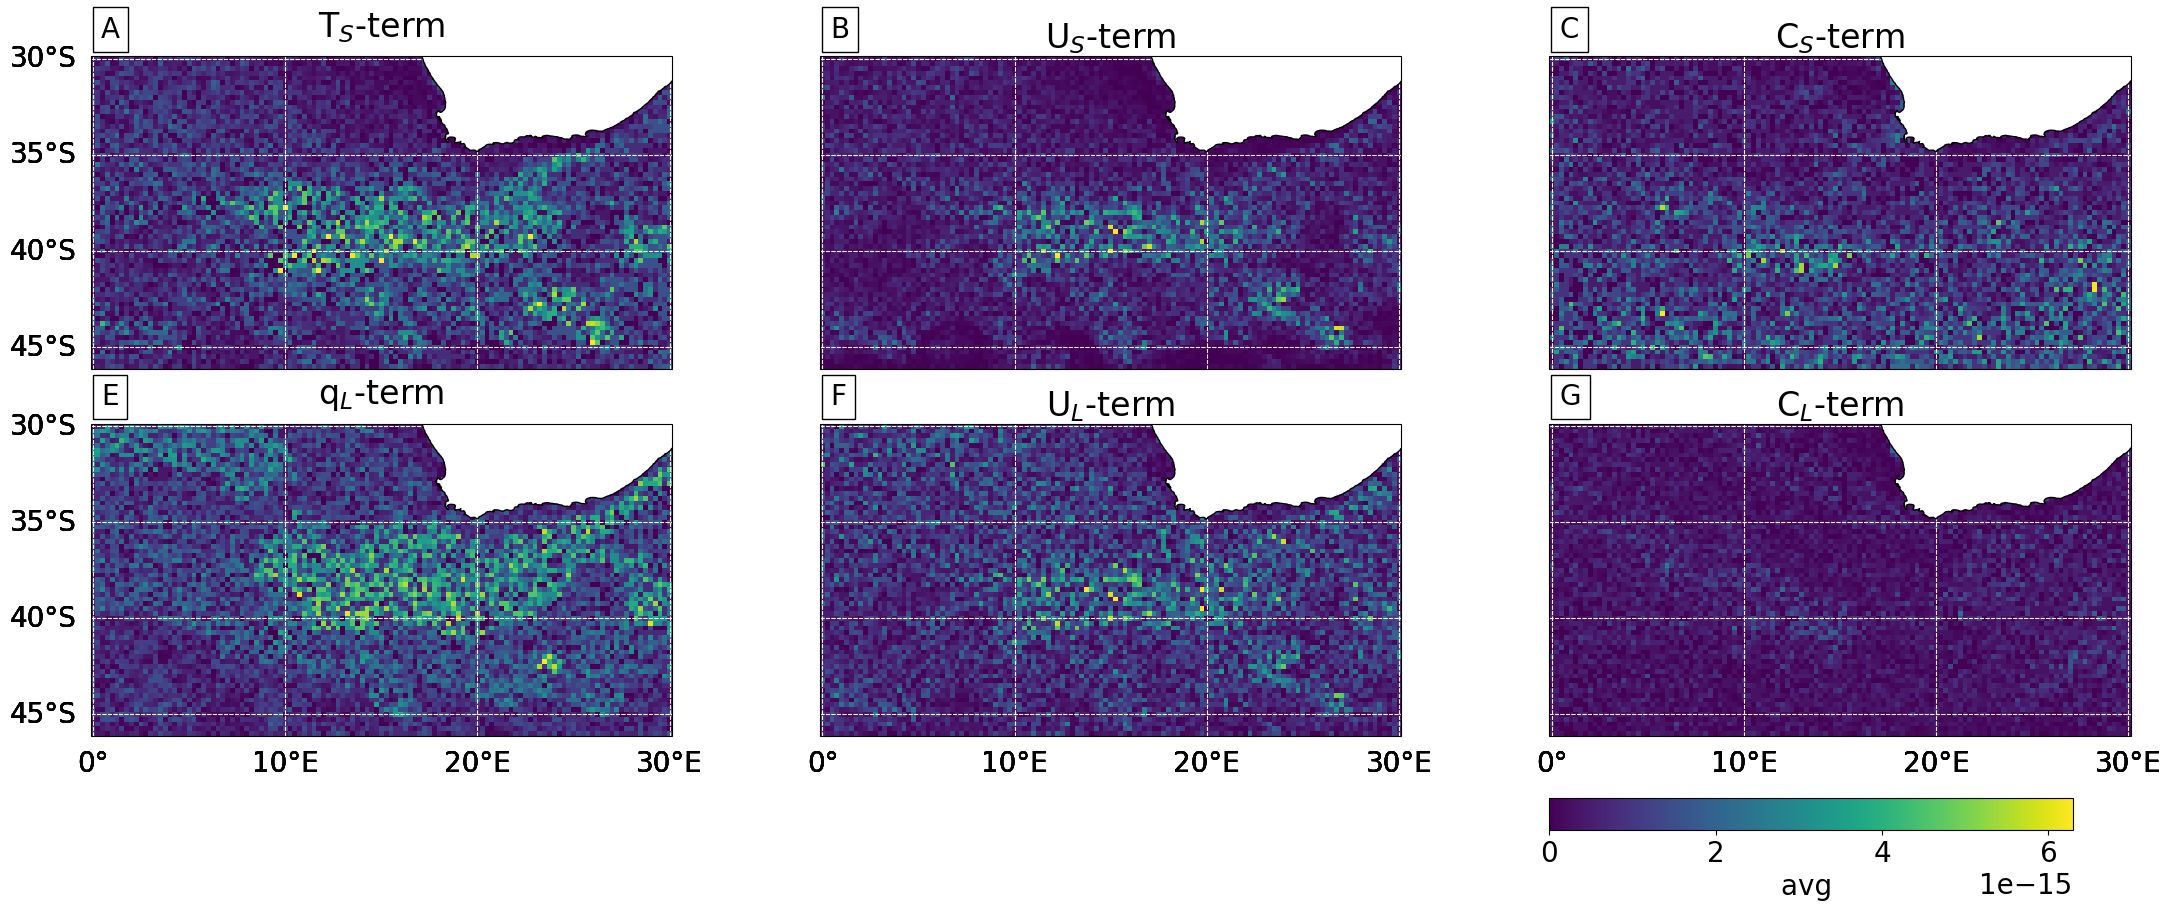

In [31]:
#time=100
vmin_l=None#0 #rec_ds.cov_term_q.min().values
vmax_l=None#np.abs(rec_ds.u_term_q).max() #rec_ds.cov_term_q.max().values

vmin_s=vmin_l
vmax_s=vmax_l
cmap=None

rec_ds=rec_avg


fig, ax=plt.subplots(2,3, figsize=[22,9], constrained_layout=True, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})

#ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.shf_fluc)#, vmin=vmin_s, vmax=vmax_s, cmap=cmap )

ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, np.abs(rec_ds.t_term), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
ax[0,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, np.abs(rec_ds.u_term_t), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
cbar_s=ax[0,2].pcolormesh(ERA5big.longitude, ERA5big.latitude,np.abs(rec_ds.cov_term_t), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
#plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')


#ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.lhf_fluc)#, vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude,np.abs(rec_ds.q_term), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
ax[1,1].pcolormesh(ERA5big.longitude, ERA5big.latitude, np.abs(rec_ds.u_term_q), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
cbar_l=ax[1,2].pcolormesh(ERA5big.longitude, ERA5big.latitude, np.abs(rec_ds.cov_term_q), vmin=vmin_l, vmax=vmax_l, cmap=cmap )

cax = ax[1,2].inset_axes([0, -0.3, 0.9, 0.1])
cbar=fig.colorbar(cbar_l, cax=cax, label=('avg '), orientation='horizontal')

cbar.ax.tick_params(labelsize=20)


#plt.colorbar(cbar_l, ax=ax[1,2], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')


#ax[0,0].set_title('Q$^\prime$$_S$')
ax[0,0].set_title('T$_S$-term')
ax[0,1].set_title('U$_S$-term')
ax[0,2].set_title('C$_S$-term')

#ax[1,0].set_title('Q$^\prime$$_L$')
ax[1,0].set_title('q$_L$-term')
ax[1,1].set_title('U$_L$-term')
ax[1,2].set_title('C$_L$-term')
alpha=0.4

#ax[0,0].grid(alpha=alpha)
ax[0,0].grid(alpha=alpha)
ax[0,1].grid(alpha=alpha)
ax[0,2].grid(alpha=alpha)

#ax[1,0].grid(alpha=alpha)
ax[1,0].grid(alpha=alpha)
ax[1,1].grid(alpha=alpha)
ax[1,2].grid(alpha=alpha)


#ax[1,0].set_xlabel('Longitude [°E]')
ax[1,0].set_xlabel('Longitude [°E]')
ax[1,1].set_xlabel('Longitude [°E]')
ax[1,2].set_xlabel('Longitude [°E]')

ax[0,0].set_ylabel('Latitude [°N]')
ax[1,0].set_ylabel('Latitude [°N]')



fig_labels=[['A','B','C','D'],['E','F','G','H']]

x=0.018
y=1.06

ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
#ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)

ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
#ax[1,3].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)

ToF_bottom1=[False, False, False, False]
ToF_left1=[True, False, False, False]

ToF_bottom=[True, True, True, True]
ToF_left=[True, False, False, False]

# Add land and coastline
for i in np.arange(3):    
    ax[0,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    ax[1,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)

#    ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    

#    ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
#    ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')


    
    for k,spine in ax[0,i].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[0,i],10,5, ToF_bottom1[i], ToF_left1[i])
    
    for k,spine in ax[1,i].spines.items():  #ax.spines is a dictionary
            spine.set_zorder(12)
            gridlines(ax[1,i],10,5, ToF_bottom[i], ToF_left[i])


#ax[1,1].legend(bbox_to_anchor=[0.99,-0.12])


#bbox = dict(boxstyle="square", fc='w')
#ax[1,2].annotate((pd.to_datetime(rec_ds.time[i].values).strftime("%m/%d/%Y, %H:%M")), xy=(-0.15, -0.3), xycoords='axes fraction', bbox=bbox,fontsize=25)

#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

## If necessary to rebuild rec_r2, run below code

Build empty xarray to inset correlation

In [33]:
rec_ds_out_1=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleERA5_out_1.nc')

In [34]:
s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

In [35]:


rec_r2=ERA5big.copy().drop(['u10','v10','d2m','t2m','P_SEA','dwlw','dwsw','msdwswrfcs','mslhf','msshf','sst','WIND_CORR10','rh','msdwlwrfcs','skt']).drop('time')
arr= np.ndarray((65,121))*np.nan

for i in np.arange(3):
    rec_r2[s_terms[i]]=xr.DataArray(arr.copy(),dims=('latitude','longitude'))
    rec_r2[l_terms[i]]=xr.DataArray(arr.copy(),dims=('latitude','longitude'))


In [37]:
for lat in tqdm(np.arange(len(rec_ds_out_1.latitude))):
    
    for lon in np.arange(len(rec_ds_out_1.longitude)):
        rec=rec_ds_out_1.isel(latitude=lat, longitude=lon)

        msk2=np.isfinite(rec.shf_fluc)

        
        for i in np.arange(3):
            msk=np.isfinite(rec[s_terms[i]])
            rec_r2[s_terms[i]][lat,lon]=scipy.stats.linregress(rec.shf_fluc.sel(time=msk & msk2), rec[s_terms[i]].sel(time=msk& msk2)).rvalue**2
            rec_r2[l_terms[i]][lat,lon]=scipy.stats.linregress(rec.lhf_fluc.sel(time=msk & msk2), rec[l_terms[i]].sel(time=msk & msk2)).rvalue**2

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [10:48<00:00,  9.98s/it]


In [38]:
rec_r2.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscaleCORR_R2_out_1.nc')

## If necessary to rebuild rec_avg, run bellw cells

In [21]:
s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

labelS = ['T$_S$-term', 'U$_S$-term', 'C$_S$-term']
labelL = ['q$_L$-term', 'U$_L$-term', 'C$_L$-term']

In [19]:
rec_avg=ERA5big.copy().drop(['u10','v10','d2m','t2m','P_SEA','dwlw','dwsw','msdwswrfcs','mslhf','msshf','sst','WIND_CORR10','rh','msdwlwrfcs','skt']).drop('time')
arr= np.ndarray((65,121))*np.nan

for i in np.arange(3):
    rec_avg[s_terms[i]]=xr.DataArray(arr.copy(),dims=('latitude','longitude'))
    rec_avg[l_terms[i]]=xr.DataArray(arr.copy(),dims=('latitude','longitude'))


In [21]:
for lat in tqdm(np.arange(len(rec_ds_ERA5.latitude))):
    
    for lon in np.arange(len(rec_ds_ERA5.longitude)):
        rec=rec_ds_ERA5.isel(latitude=lat, longitude=lon)

        
        for i in np.arange(3):
            msk=np.isfinite(rec[s_terms[i]])
            rec_avg[s_terms[i]][lat,lon]=np.mean(rec[s_terms[i]].sel(time=msk))
            rec_avg[l_terms[i]][lat,lon]=np.mean(rec[l_terms[i]].sel(time=msk))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [11:06<00:00, 10.26s/it]


In [22]:
rec_avg.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscale_AVG_remove_if_redo.nc')

In [25]:
i=0
lat=1
lon=1

msk=np.isfinite(rec[s_terms[i]])

rec=rec_ds_ERA5.isel(latitude=lat, longitude=lon)
np.mean(rec[s_terms[i]].sel(time=msk))

<xarray.DataArray 't_term' ()>
array(1.38896564e-16)
Coordinates:
    longitude  float32 0.25
    latitude   float32 -30.25

## Absolute magnitude of variability

In [7]:
rec_abs=xr.open_dataset(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscale_ABS_FLUC.nc')
import cmocean as cmo

In [8]:
def plot_upscale_abs(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=1, figsize=[30,11]):
    
    fig, ax=plt.subplots(2,4, figsize=figsize, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    
    
    ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.abs_fluc_shf.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    
    ax[0,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    ax[0,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    cbar_s=ax[0,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmap )
    #plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')
    
    
    ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.abs_fluc_lhf.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    ax[1,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    cbar_l=ax[1,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmap )
    
    cax = ax[1,3].inset_axes([0, -0.3, 0.9, 0.1])
    cbar=fig.colorbar(cbar_l, cax=cax, label=('Contribution to Q$^\prime$ [W/m$^2$] '), orientation='horizontal')
    
    cbar.ax.tick_params(labelsize=20)
    
    
    #plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')
    
    
    ax[0,0].set_title('Absolute variabilty')
    ax[0,0+1].set_title('T$_S$-term')
    ax[0,1+1].set_title('U$_S$-term')
    ax[0,2+1].set_title('C$_S$-term')
    
    ax[1,0].set_title('Absolute variabilty')
    ax[1,0+1].set_title('q$_L$-term')
    ax[1,1+1].set_title('U$_L$-term')
    ax[1,2+1].set_title('C$_L$-term')
    alpha=0.4
    
    ax[0,0].grid(alpha=alpha)
    ax[0,0+1].grid(alpha=alpha)
    ax[0,1+1].grid(alpha=alpha)
    ax[0,2+1].grid(alpha=alpha)
    
    ax[1,0].grid(alpha=alpha)
    ax[1,0+1].grid(alpha=alpha)
    ax[1,1+1].grid(alpha=alpha)
    ax[1,2+1].grid(alpha=alpha)
    
    
    ax[1,0].set_xlabel('Longitude [°E]')
    ax[1,0+1].set_xlabel('Longitude [°E]')
    ax[1,1+1].set_xlabel('Longitude [°E]')
    ax[1,2+1].set_xlabel('Longitude [°E]')
    
    ax[0,0].set_ylabel('Latitude [°N]')
    ax[1,0].set_ylabel('Latitude [°N]')
    
    
    
    fig_labels=[['A','B','C','D'],['E','F','G','H']]
    
    x=0.018
    y=1.085
    
    ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
    ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,3].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
    ToF_bottom1=[False, False, False, False]
    ToF_left1=[True, False, False, False]
    
    ToF_bottom=[True, True, True, True]
    ToF_left=[True, False, False, False]
    
    # Add land and coastline
    for i in np.arange(4):    
        ax[0,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
        ax[1,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    
        ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
        
    
        ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    
    
        
        for k,spine in ax[0,i].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[0,i],10,5, ToF_bottom1[i], ToF_left1[i])
        
        for k,spine in ax[1,i].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[1,i],10,5, ToF_bottom[i], ToF_left[i])
    
    
    
    ax[1,2].annotate((pd.to_datetime(rec_ds.time[i].values).strftime("%m/%d/%Y, %H:%M")), xy=(0.15, -0.4), xycoords='axes fraction', bbox=bbox,fontsize=25)
    
    
    ax[1,0].set_xlim(rec_ds.longitude.min(),rec_ds.longitude.max())
    ax[1,0].set_ylim(rec_ds.latitude.min(),rec_ds.latitude.max())       
    
    #EDDIES
    
    if eddy_plot == 1:
        for i in np.arange(len(eddies)):
            d = eddies[i]['date_num']
        
            py_date = np.datetime64(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d % 1) - datetime.timedelta(days=366), 'ms')
            if py_date.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(4):
                    plot_eddies(eddies[i], ax[0,frame])
                    plot_eddies(eddies[i], ax[1,frame])
                break
                
    ax[1,1].legend(bbox_to_anchor=[0.67, -0.13], ncols=2)
    if ani_fig_save==1:
        plt.savefig(pathlib.Path('.').absolute().parent/ f'MTmichaela/ani_fig_abs_mag/pic_{time:04}.png')

    else:
         plt.show()
#    plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/test.png')
#    plt.tight_layout()
   
    plt.close(fig)
#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

In [9]:

time=1
vmin_l=0
vmax_l=200

vmin_s=vmin_l
vmax_s=vmax_l

rec_ds=rec_abs

eddy_plot=1 #Plot eddies or not, =1 plots eddies

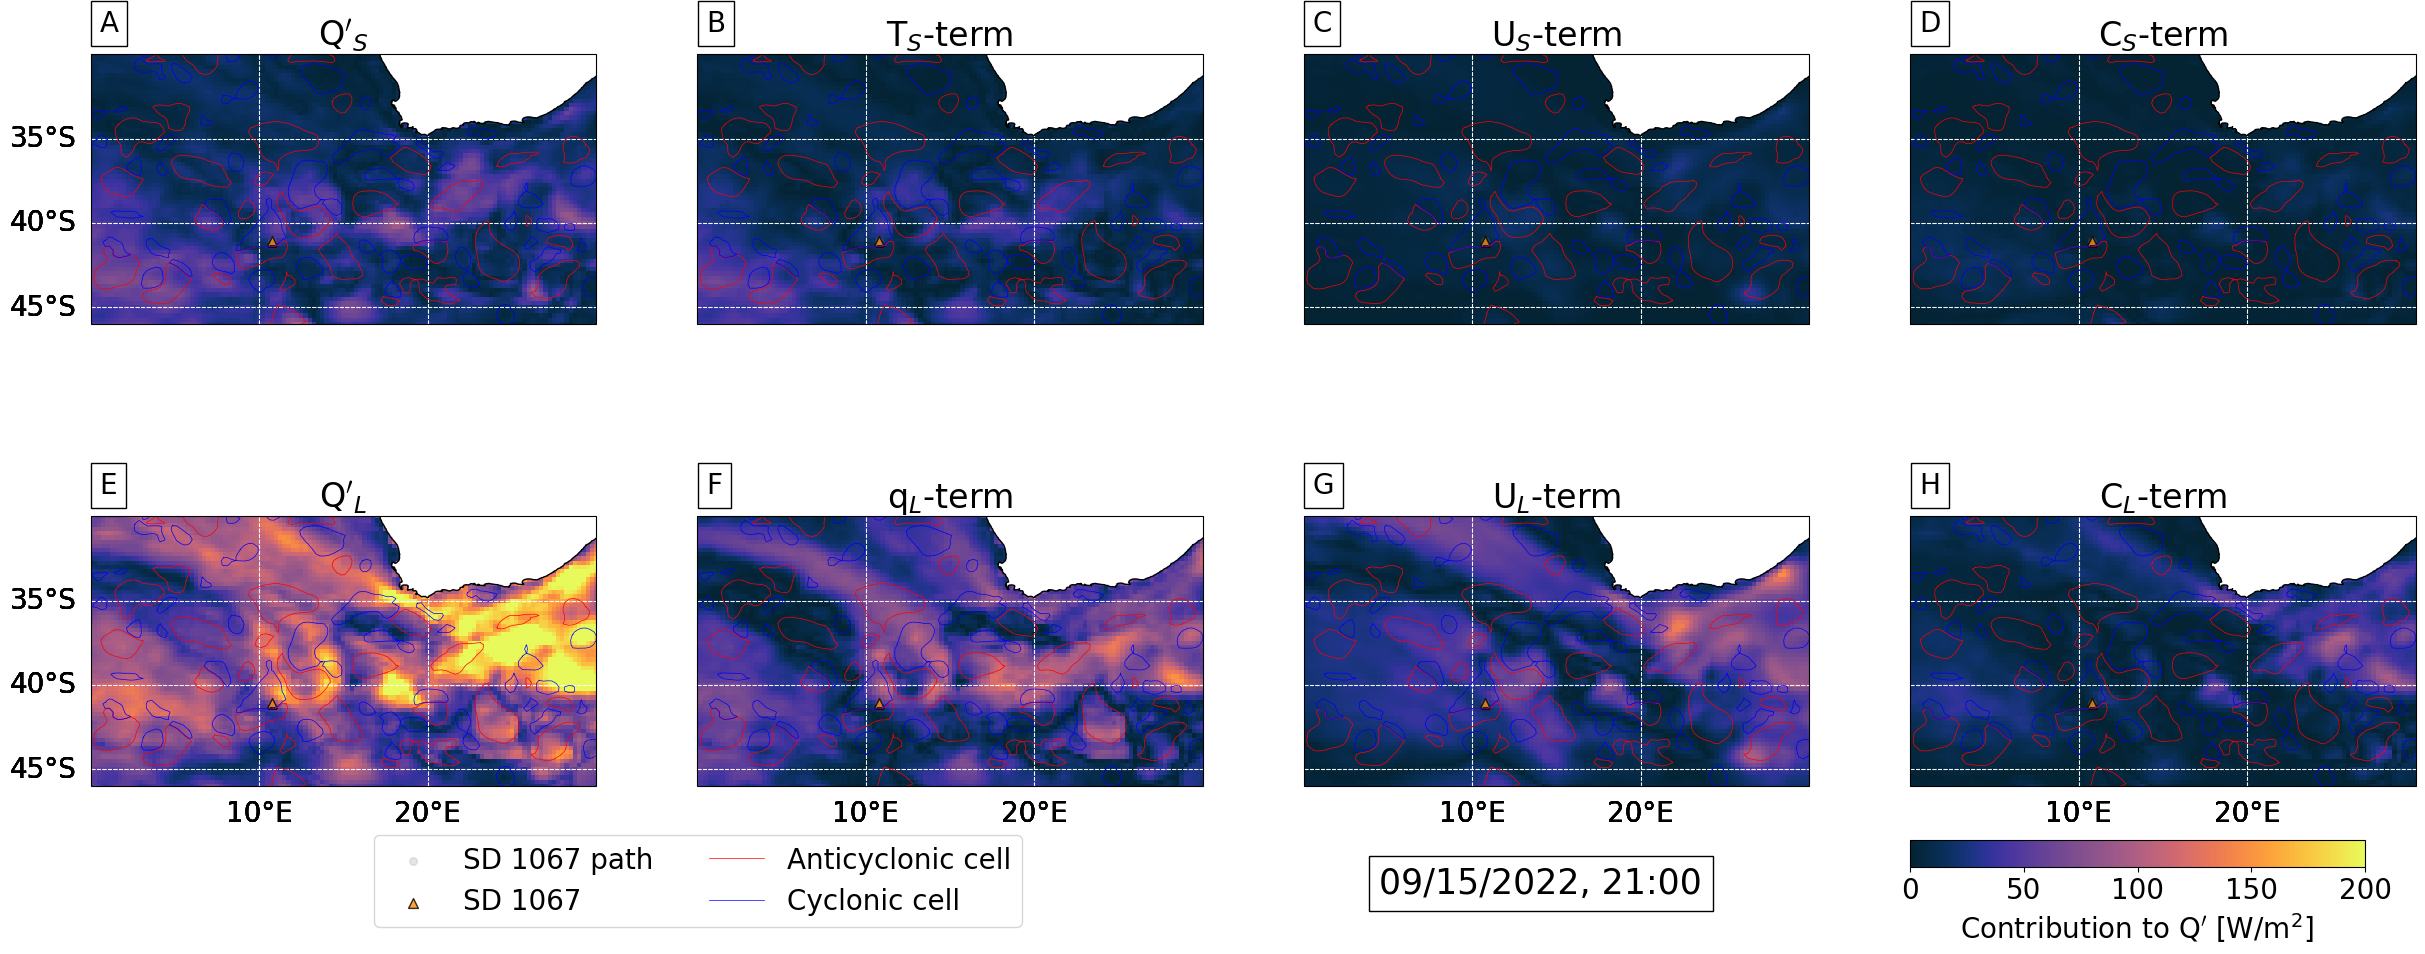

In [28]:
plot_upscale_abs(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap=cmo.cm.thermal,bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=0, figsize=[30,11])

In [12]:
rec_ds=rec_abs #Choose dataset


for time in tqdm(np.arange(1341, len(rec_ds.time))):
    plot_upscale_abs(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap=cmo.cm.thermal,bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=1, figsize=[30,11])

100%|██████████████████████████████████████████████████████████████████████████████████| 297/297 [14:48<00:00,  2.99s/it]


In [13]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ 'MTmichaela/ani_fig_abs_mag'
fps=8

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('terms_abs_mag.mp4')

Moviepy - Building video terms_abs_mag.mp4.
Moviepy - Writing video terms_abs_mag.mp4



Moviepy - Done !
Moviepy - video ready terms_abs_mag.mp4


## Percentage of variability

In [11]:
def plot_upscale_abs_procent(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=1, figsize=[30,11]):
    
    fig, ax=plt.subplots(2,4, figsize=figsize, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    
    
    cbar_s=ax[0,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.abs_fluc_shf.isel(time=time), vmin=vmin_s, vmax=vmax_s, cmap=cmo.cm.thermal )

    bax = ax[1,0].inset_axes([0, -0.3, 0.9, 0.1])
    bbar=fig.colorbar(cbar_s, cax=bax, label=('Absolute variability [W/m$^2$] '), orientation='horizontal')
    bbar.ax.tick_params(labelsize=20)
    
    
    ax[0,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.t_term.isel(time=time)/rec_ds.abs_fluc_shf.isel(time=time)*100, vmin=0, vmax=100, cmap=cmap )
    ax[0,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_t.isel(time=time)/rec_ds.abs_fluc_shf.isel(time=time)*100, vmin=0, vmax=100, cmap=cmap )
    ax[0,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_t.isel(time=time)/rec_ds.abs_fluc_shf.isel(time=time)*100, vmin=0, vmax=100, cmap=cmap )
    #plt.colorbar(cbar_s, ax=ax[0,2+1], label='Contribution to Q$^\prime _{S}$ [W/m$^2$] ')
    
    
    ax[1,0].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.abs_fluc_lhf.isel(time=time), vmin=vmin_l, vmax=vmax_l, cmap=cmo.cm.thermal )
    
    ax[1,0+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.q_term.isel(time=time)/rec_ds.abs_fluc_lhf.isel(time=time)*100, vmin=0, vmax=100, cmap=cmap )
    ax[1,1+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.u_term_q.isel(time=time)/rec_ds.abs_fluc_lhf.isel(time=time)*100, vmin=0, vmax=100, cmap=cmap )
    cbar_l=ax[1,2+1].pcolormesh(ERA5big.longitude, ERA5big.latitude, rec_ds.cov_term_q.isel(time=time)/rec_ds.abs_fluc_lhf.isel(time=time)*100, vmin=0, vmax=100, cmap=cmap )
    
    cax = ax[1,3].inset_axes([0, -0.3, 0.9, 0.1])
    cbar=fig.colorbar(cbar_l, cax=cax, label=('Contribution to Absolute variability [%] '), orientation='horizontal')
    
    cbar.ax.tick_params(labelsize=20)
    
    
    #plt.colorbar(cbar_l, ax=ax[1,3], label='Contribution to Q$^\prime$ [W/m$^2$] ', orientation='horizontal')
    
    
    ax[0,0].set_title('Absolute variabilty')
    ax[0,0+1].set_title('T$_S$-term')
    ax[0,1+1].set_title('U$_S$-term')
    ax[0,2+1].set_title('C$_S$-term')
    
    ax[1,0].set_title('Absolute variabilty')
    ax[1,0+1].set_title('q$_L$-term')
    ax[1,1+1].set_title('U$_L$-term')
    ax[1,2+1].set_title('C$_L$-term')
    alpha=0.4
    
    ax[0,0].grid(alpha=alpha)
    ax[0,0+1].grid(alpha=alpha)
    ax[0,1+1].grid(alpha=alpha)
    ax[0,2+1].grid(alpha=alpha)
    
    ax[1,0].grid(alpha=alpha)
    ax[1,0+1].grid(alpha=alpha)
    ax[1,1+1].grid(alpha=alpha)
    ax[1,2+1].grid(alpha=alpha)
    
    
    ax[1,0].set_xlabel('Longitude [°E]')
    ax[1,0+1].set_xlabel('Longitude [°E]')
    ax[1,1+1].set_xlabel('Longitude [°E]')
    ax[1,2+1].set_xlabel('Longitude [°E]')
    
    ax[0,0].set_ylabel('Latitude [°N]')
    ax[1,0].set_ylabel('Latitude [°N]')
    
    
    
    fig_labels=[['A','B','C','D'],['E','F','G','H']]
    
    x=0.018
    y=1.085
    
    ax[0,0].annotate(fig_labels[0][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,1].annotate(fig_labels[0][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,2].annotate(fig_labels[0][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[0,3].annotate(fig_labels[0][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
    ax[1,0].annotate(fig_labels[1][0], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,1].annotate(fig_labels[1][1], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,2].annotate(fig_labels[1][2], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    ax[1,3].annotate(fig_labels[1][3], xy=(x,y), xycoords='axes fraction', bbox=bbox)
    
    ToF_bottom1=[False, False, False, False]
    ToF_left1=[True, False, False, False]
    
    ToF_bottom=[True, True, True, True]
    ToF_left=[True, False, False, False]
    
    # Add land and coastline
    for i in np.arange(4):    
        ax[0,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
        ax[1,i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',facecolor='w',edgecolor='k'),zorder=3)
    
        ax[0,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[0,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
        
    
        ax[1,i].scatter(dsadcpH.longitude[:time], dsadcpH.latitude[:time], s=30, color='grey', alpha=0.2,label='SD 1067 path')
        ax[1,i].scatter(dsadcpH.longitude[time], dsadcpH.latitude[time], s=50, color='darkorange', marker='^', alpha=0.8, edgecolor='k',label='SD 1067')
    
    
        
        for k,spine in ax[0,i].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[0,i],10,5, ToF_bottom1[i], ToF_left1[i])
        
        for k,spine in ax[1,i].spines.items():  #ax.spines is a dictionary
                spine.set_zorder(12)
                gridlines(ax[1,i],10,5, ToF_bottom[i], ToF_left[i])
    
    
    
    ax[1,2].annotate((pd.to_datetime(rec_ds.time[i].values).strftime("%m/%d/%Y, %H:%M")), xy=(0.15, -0.4), xycoords='axes fraction', bbox=bbox,fontsize=25)
    
    
    ax[1,0].set_xlim(rec_ds.longitude.min(),rec_ds.longitude.max())
    ax[1,0].set_ylim(rec_ds.latitude.min(),rec_ds.latitude.max())       
    
    #EDDIES
    
    if eddy_plot == 1:
        for i in np.arange(len(eddies)):
            d = eddies[i]['date_num']
        
            py_date = np.datetime64(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d % 1) - datetime.timedelta(days=366), 'ms')
            if py_date.astype('datetime64[D]') == rec_ds.time[time].values.astype('datetime64[D]'):
                for frame in np.arange(4):
                    plot_eddies(eddies[i], ax[0,frame])
                    plot_eddies(eddies[i], ax[1,frame])
                break
                
    ax[1,1].legend(bbox_to_anchor=[1.1, -0.13], ncols=2)
    if ani_fig_save==1:
        plt.savefig(pathlib.Path('.').absolute().parent/ f'MTmichaela/ani_fig_procent/pic_{time:04}.png')

    else:
         plt.show()
#    plt.savefig(pathlib.Path('.').absolute().parent/ 'MTmichaela/test.png')
#    plt.tight_layout()
   
    plt.close(fig)
#ax[1,0].xaxis.set_ticks(ticks=np.arange(0,30,5), labels=[0,10,20,30])

In [12]:
time=1
vmin_l=0
vmax_l=200

vmin_s=vmin_l
vmax_s=vmax_l

rec_ds=rec_abs

eddy_plot=1 #Plot eddies or not, =1 plots eddies

In [15]:
plot_upscale_abs_procent(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=1, figsize=[30,11])

In [13]:
rec_ds=rec_abs #Choose dataset


for time in tqdm(np.arange(1322, len(rec_ds.time))):
    plot_upscale_abs_procent(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, ani_fig_save=1, figsize=[30,11])

100%|███████████████████████████████████████████████████████████████████████████████████████| 316/316 [15:51<00:00,  3.01s/it]


In [14]:
import moviepy.video.io.ImageSequenceClip
image_folder=pathlib.Path('.').absolute().parent/ 'MTmichaela/ani_fig_procent'
fps=8

image_files = [os.path.join(image_folder,img)
               for img in np.sort(os.listdir(image_folder))
               if img.endswith(".png")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile('terms_procent.mp4')

Moviepy - Building video terms_procent.mp4.
Moviepy - Writing video terms_procent.mp4



Moviepy - Done !
Moviepy - video ready terms_procent.mp4


## Remake upscale absolite variability data below

In [87]:
rec_ds=rec_ds_ERA5.copy()#.drop(['u10','v10','d2m','t2m','P_SEA','dwlw','dwsw','msdwswrfcs','mslhf','msshf','sst','WIND_CORR10','rh','msdwlwrfcs','skt'])
arr = np.ndarray(rec_ds_ERA5.t_term.shape) * np.nan

rec_ds['t_term']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['u_term_t']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['q_term']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['u_term_q']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_coeffs']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_coeffs']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['cov_term_t']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['cov_term_q']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_fluc']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_fluc']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['lhf_mean']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['shf_mean']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))

rec_ds['abs_fluc_lhf']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))
rec_ds['abs_fluc_shf']=xr.DataArray(arr.copy(),dims=('time','latitude','longitude'))

In [88]:
for i in tqdm(np.arange(len(rec_ds_ERA5.latitude))):
    
    for tt in np.arange(len(rec_ds_ERA5.longitude)):
        e5=rec_ds_ERA5.isel(latitude=i, longitude=tt)



        rec_ds['t_term'][:,i,tt]=np.abs( e5.t_term)
        rec_ds['u_term_t'][:,i,tt]= np.abs(e5.u_term_t)
        rec_ds['q_term'][:,i,tt]= np.abs(e5.q_term)
        rec_ds['u_term_q'][:,i,tt]= np.abs(e5.u_term_q)
        rec_ds['lhf_coeffs'][:,i,tt]= e5.lhf_coeffs
        rec_ds['shf_coeffs'][:,i,tt]= e5.shf_coeffs
        rec_ds['cov_term_t'][:,i,tt]= np.abs( e5.cov_term_t)
        rec_ds['cov_term_q'][:,i,tt]=np.abs(e5.cov_term_q)
        rec_ds['lhf_fluc'][:,i,tt]= e5.lhf_fluc
        rec_ds['shf_fluc'][:,i,tt]=e5.shf_fluc
        rec_ds['lhf_mean'][:,i,tt]=e5.lhf_mean 
        rec_ds['shf_mean'][:,i,tt]=e5.shf_mean
        rec_ds['abs_fluc_lhf'][:,i,tt]=(np.abs(e5.q_term)+np.abs(e5.u_term_q)+np.abs(e5.cov_term_q)) 
        rec_ds['abs_fluc_shf'][:,i,tt]=(np.abs(e5.t_term)+np.abs(e5.u_term_t)+np.abs(e5.cov_term_t)) 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [06:05<00:00,  5.63s/it]


In [91]:
rec_ds.to_netcdf(pathlib.Path('.').absolute().parent/ 'MTmichaela/MasterH23/upscale_ABS_FLUC.nc')

In [20]:
rec_ds=rec_abs

NameError: name 'rec_abs' is not defined

## Whats wrong with lhf terms?

* I think the problem is the twice multiplied with coeffs. Just removed it. Chenge colorbar to continous

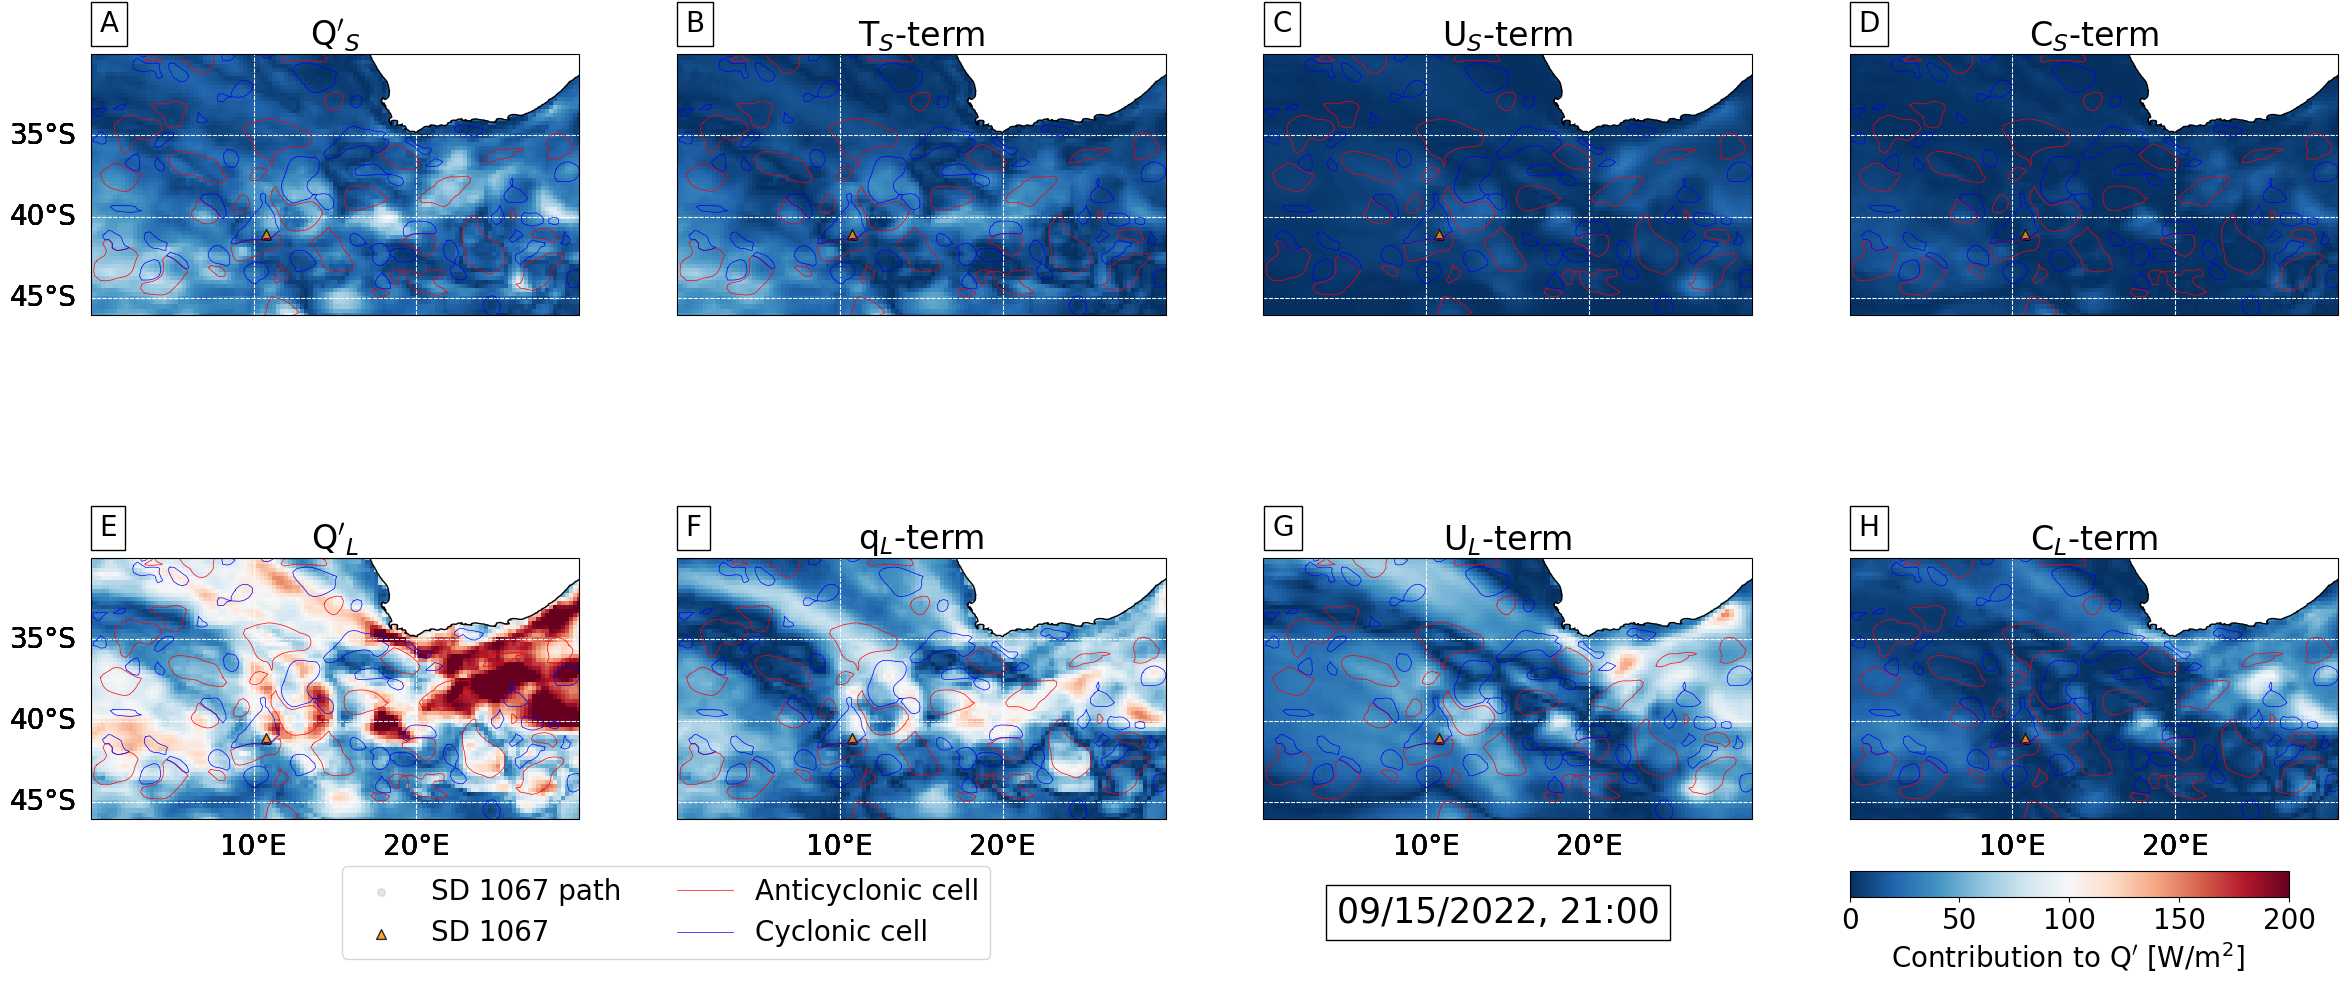

In [96]:
plot_upscale_abs(time, vmin_l, vmax_l, vmin_s, vmax_s, cmap='RdBu_r',bbox = dict(boxstyle="square", fc='w'), eddy_plot=1, figsize=[29,12])

In [59]:
msk=np.isfinite(rec[s_terms[i]])
msk1=np.isfinite(rec.shf_fluc)
rec_r2[s_terms[i]][i,tt]=scipy.stats.linregress(rec.shf_fluc.sel(time=msk & msk1), rec[s_terms[i]].sel(time=msk & msk1)).rvalue**2

In [60]:
rec_r2[s_terms[i]][i,tt]

<xarray.DataArray 'cov_term_t' ()>
array(0.20038635)
Coordinates:
    longitude  float32 30.0
    latitude   float32 -30.5

In [32]:
for i in tqdm(np.arange(len(rec_ds_ERA5.latitude))):
    
    for tt in np.arange(len(rec_ds_ERA5.longitude)):
        rec=rec_ds_ERA5.isel(latitude=i, longitude=tt)
    



<xarray.Dataset>
Dimensions:         (longitude: 121, latitude: 65, time: 1638)
Coordinates:
  * longitude       (longitude) float32 0.0 0.25 0.5 0.75 ... 29.5 29.75 30.0
  * latitude        (latitude) float32 -30.0 -30.25 -30.5 ... -45.5 -45.75 -46.0
  * time            (time) datetime64[ns] 2022-09-15T18:00:00 ... 2022-11-22T...
Data variables: (12/15)
    skt             (time, latitude, longitude) float32 ...
    t_term          (time, latitude, longitude) float64 ...
    u_term_t        (time, latitude, longitude) float64 ...
    q_term          (time, latitude, longitude) float64 ...
    u_term_q        (time, latitude, longitude) float64 ...
    lhf_coeffs      (time, latitude, longitude) float64 ...
    ...              ...
    lhf_fluc        (time, latitude, longitude) float64 ...
    shf_fluc        (time, latitude, longitude) float64 ...
    lhf_mean        (time, latitude, longitude) float64 ...
    shf_mean        (time, latitude, longitude) float64 ...
    lhf_recomposed  (time, latitude, longitude) float64 ...
    shf_recomposed  (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-09 13:22:35 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [41]:
s_terms=['t_term', 'u_term_t', 'cov_term_t']
l_terms=['q_term', 'u_term_q', 'cov_term_q']

i=3
tt=49

rec=rec_ds_ERA5.isel(latitude=i, longitude=tt)

for i in np.arange(3):
    scipy.stats.linregress(rec.shf_fluc, rec[s_terms[i]]).rvalue
    scipy.stats.linregress(rec.lhf_fluc, rec[l_terms[i]]).rvalue

100%|██████████████████████████████████████████████████████████████████████████████████████████| 69/69 [00:37<00:00,  1.82it/s]


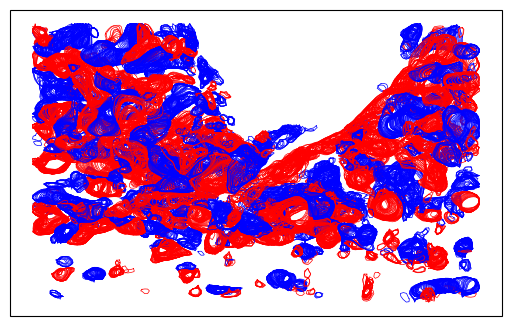

In [11]:
fig, ax=plt.subplots(figsize=[5,5], constrained_layout=True, sharey=True, sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
for fname in tqdm(eddy_files):
    
    # load eddy file for the day
    
    eddies = mat73.loadmat(fname)
    
    # define the date of the eddy file
    
    d = eddies['date_num']

    py_date = np.datetime64(datetime.datetime.fromordinal(int(d)) + datetime.timedelta(days=d % 1) - datetime.timedelta(days=366), 'ms')

    plot_eddies(eddies, ax)

#    ax.contour(eddies['X'], eddies['Y'], eddies['ADT'].T, levels=[-0.48, 0.03, 0.350], colors='k',linestyles='solid', linewidths=1.5, zorder=10, transform=ccrs.PlateCarree()) # PF, SAF, STF